In [80]:
import nltk
import pandas as pd
import os
import re
import pickle
from nltk import FreqDist
import numpy as np
import google_conf
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)



from sklearn.metrics.pairwise import cosine_similarity

In [81]:
pop_data = google_conf.setup(sheet_url="https://docs.google.com/spreadsheets/d/1o8L0Rt4CzQ_DcYdaKgCdige4nJs0sydlTGiMBSstQtc/edit?usp=sharing", service_account_path="../../ServiceAccountsKey.json")

In [82]:
articles_metadata = pd.read_json("../data/article_metadata.json")
articles_metadata.head(5)

pop_id  year                 authors                            journal  \
0       0  2011              Bos et al.            Political Communication   
1       1  2019         Blassnig et al.            Political Communication   
2       2  2017                Caramani  American Political Science Review   
3       3  2020  Wuttke,Schimpf, Schoen  American Political Science Review   
4       4  2014                   Treib  Journal of European Public Policy   

                                               title     type  \
0  How the Media Shape Perceptions of Right-Wing ...  article   
1  Hitting a Nerve: Populist News Articles Lead t...  article   
2  Will vs. Reason: The Populist and Technocratic...  article   
3  When the Whole Is Greater than the Sum of Its ...  article   
4  The voter says no, but nobody listens: causes ...  article   

                                            filepath  
0  Political Communication/2011 - Bos et al. - Ho...  
1  Political Communication/2019 - Blassing et al....  
2  American Political Science Review/2017 - Caram...  
3  American Political Science Review/2020 - Wuttk...  
4  Journal of European Public Policy/2014 - Treib...

In [83]:
popid_year_dict = dict(zip(articles_metadata["pop_id"], articles_metadata["year"]))

In [84]:
# generating a new working title
articles_metadata["working_title"] = articles_metadata.apply(lambda row: row["authors"] + " " + str(row["year"]), axis=1)

In [85]:
title_freqs_dict = dict([el for el in FreqDist(articles_metadata["working_title"]).items() if el[1] > 1])
title_freqs_dict

{'Schmidt 2019': 2,
 'Rooduijn 2018': 2,
 'Grzymala-Busse 2019': 4,
 'Marcos-Marne et al. 2020': 2,
 'Mudde 2014': 2,
 'Kriesi 2020': 2,
 'Rooduijn 2014': 2,
 'Jones 2019': 2}

In [86]:
letters = ["a", "b", "c", "d", "e"]
met = []
new_titles = []
for title in articles_metadata["working_title"]:
    if title in title_freqs_dict.keys():
        for n in range(title_freqs_dict[title]):
            letter = letters[n]
            title_letter = title + letter
            if title_letter not in met:
                new_titles.append(title_letter)
                met.append(title_letter)
                break
    else:
        new_titles.append(title)


In [87]:
articles_metadata["working_title"] = new_titles

In [88]:
popid_title_dict = dict(zip(articles_metadata["pop_id"], articles_metadata["working_title"]))

In [89]:
poptypes_df = pd.read_csv("../data/poptypes_df.csv")
poptypes_df["variants"] = poptypes_df["variants"].apply(eval)
poptypes_df

Unnamed: 0        poptype  \
0           0     right-wing   
1           1      left-wing   
2           2    nationalist   
3           6  authoritatian   
4           8   exclusionary   
5           4        radical   
6           3       nativist   
7           7   inclusionary   
8           9     neoliberal   
9           5       moderate   

                                            variants  count  
0  [right-wing, right, right-, rightwe, radical-r...   2094  
1  [left-wing, left, left-, leftist, radical-left...    652  
2  [nationalism, nationalist, national, nation, e...    260  
3                  [authoritarian, authoritarianism]    157  
4  [exclusionary, exclusion, exclusive, exclusive...    116  
5                   [radical, radicalism, radically]    115  
6                               [nativism, nativist]     74  
7               [inclusionary, inclusive, inclusion]     67  
8           [neoliberal, neo-liberal, neoliberalism]     65  
9                             [moderate, moderately]     44

In [90]:
poptypes_dict = dict(zip(poptypes_df["poptype"], poptypes_df["variants"]))
poptypes_dict

{'right-wing': ['right-wing',
  'right',
  'right-',
  'rightwe',
  'radical-right',
  'radical-right-wing',
  'far-right',
  'rightist',
  'right-leaning',
  'radicalright',
  'rightwing',
  'extreme-right',
  'farright'],
 'left-wing': ['left-wing',
  'left',
  'left-',
  'leftist',
  'radical-left',
  'leftwing',
  'left-leaning',
  'leftwe',
  'leftism',
  'center-left',
  'radicalleft'],
 'nationalist': ['nationalism',
  'nationalist',
  'national',
  'nation',
  'ethno-nationalist',
  'nationalistic',
  'neo-nationalism'],
 'authoritatian': ['authoritarian', 'authoritarianism'],
 'exclusionary': ['exclusionary',
  'exclusion',
  'exclusive',
  'exclusively',
  'exclusionist'],
 'radical': ['radical', 'radicalism', 'radically'],
 'nativist': ['nativism', 'nativist'],
 'inclusionary': ['inclusionary', 'inclusive', 'inclusion'],
 'neoliberal': ['neoliberal', 'neo-liberal', 'neoliberalism'],
 'moderate': ['moderate', 'moderately']}

In [91]:
poptypes = poptypes_df["poptype"].tolist()

# read the concordance data

In [92]:
path = "../data/large_data/populis_conc10_min/"
all_concs = []
for pop_id in articles_metadata["pop_id"]:
    filename = "populis_conc10_pop_id_{}.txt".format(str(pop_id))
    filepath = path + filename
    year = popid_year_dict[pop_id]
    title = popid_title_dict[pop_id]
    with open(filepath, "r") as f:
        lines = f.readlines()
    lines_splitted = [l.split() for l in lines]
    lines_splitted = [(conc, str(year), title) for conc in lines_splitted]
    all_concs.extend(lines_splitted)

In [93]:
len(all_concs)

39605

In [94]:
conc_lengths = [len(conc[0]) for conc in all_concs]
len([l for l in conc_lengths if l==21])

39199

In [95]:
concs_covered_types = []
for conc, year, title in all_concs:
    conc = [w for w in conc if w not in ["populist", "populism"]]
    covered_types = []
    for key in poptypes_dict.keys():
        if set(poptypes_dict[key]) & set(conc):
            covered_types.append(key)
            conc = [w for w in conc if w not in poptypes_dict[key]]
    concs_covered_types.append((conc, covered_types, year, title))

In [96]:
concs_covered_types[:10]

[(['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article'],
  ['right-wing'],
  '2011',
  'Bos et al. 2011'),
 (['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article',
   'view',
   'view',
   'relate',
   'article'],
  ['right-wing'],
  '2011',
  'Bos et al. 2011'),
 (['view',
   'view',
   'relate',
   'article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn'],
  ['right-wing'],
  '2011',
  'Bos et al. 2011'),
 (['article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn',
   'key',
   'electoral',
   'success'],
  ['right-wing'],
  '2011',
  'B

In [97]:
len([el for el in concs_covered_types if bool(el[1])]) # previously 12255

12793

In [98]:
len([el for el in concs_covered_types if len(el[1])==1])

7915

In [99]:
concs_labeled = [(el[0], el[1][0], el[2], el[3]) for el in concs_covered_types if len(el[1])==1]
len(concs_labeled)

7915

In [100]:
concs_labeled[:5]

[(['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article',
   'view',
   'view',
   'relate',
   'article'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['view',
   'view',
   'relate',
   'article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn',
   'key',
   'electoral',
   'success'],
  'right-wing',
  '2011',
  'Bos et al

In [101]:
with open("../data/concs_labeled_min.pickle", "wb") as f:
    pickle.dump(concs_labeled, f)

In [178]:
concs_labeled_df = pd.DataFrame(concs_labeled, columns=["conc", "type", "year", "title"])
concs_labeled_df.to_csv("../data/concs_labeled_df.csv")

# Technocratic populism exploration

In [103]:
concs_covered_types[0]

(['access',
  'use',
  'find',
  'print',
  'homepage',
  'cite',
  'article',
  'publish',
  'online',
  'submit',
  'article',
  'journal',
  'article'],
 ['right-wing'],
 '2011',
 'Bos et al. 2011')

In [104]:
all_concs[:3]

[(['access',
   'use',
   'find',
   'print',
   'homepage',
   'right-wing',
   'populist',
   'cite',
   'article',
   'right-wing',
   'populist',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article'],
  '2011',
  'Bos et al. 2011'),
 (['access',
   'use',
   'find',
   'print',
   'homepage',
   'right-wing',
   'populist',
   'cite',
   'article',
   'right-wing',
   'populist',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article',
   'view',
   'view',
   'relate',
   'article'],
  '2011',
  'Bos et al. 2011'),
 (['view',
   'view',
   'relate',
   'article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'right-wing',
   'populist',
   'argue',
   'right-wing',
   'populist',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn'],
  '2011',
  'Bos et al. 2011')]

In [105]:
technocratic_preceding_N = 0
for conc, year, title in all_concs:
    try:
        inx = [t[0] for t in enumerate(conc) if re.search("populis", t[1], re.IGNORECASE)][0]
        if conc[inx-1] == "technocratic":
            technocratic_preceding_N += 1
    except:
        pass


In [106]:
technocratic_preceding_N

25

In [110]:
concs_covered_types_tech = []
for conc_data in concs_covered_types:
    if set(["technocratic"]) & set(conc_data[0]):
        #if len(conc_data[1]) == 0:
            concs_covered_types_tech.append((conc_data[0], "technocratic", conc_data[2], conc_data[3]))

In [111]:
len(concs_covered_types_tech)

254

In [112]:
concs_covered_types_tech_df = pd.DataFrame(concs_covered_types_tech)
concs_covered_types_tech_df.rename(columns={0 : "conc", 1 : "poptype", 2 : "year", 3 : "title"}, inplace=True)
concs_covered_types_tech_df.head(10)

conc       poptype  year  \
0  [reason, article, compare, analytically, techn...  technocratic  2017   
1  [analytically, technocracy, alternative, form,...  technocratic  2017   
2  [require, voter, delegate, authority, leader, ...  technocratic  2017   
3  [bolivarian, clothe, party, like, die, note, t...  technocratic  2017   
4  [proportional, representation, party, structur...  technocratic  2017   
5  [party, capacity, foster, loyalty, party, repr...  technocratic  2017   
6  [view, competition, matter, party, over-respon...  technocratic  2017   
7  [limit, possibility, act, merely, managerial, ...  technocratic  2017   
8  [complexity, network, governance, consequently...  technocratic  2017   
9  [main, section, article, address, way, alterna...  technocratic  2017   

           title  
0  Caramani 2017  
1  Caramani 2017  
2  Caramani 2017  
3  Caramani 2017  
4  Caramani 2017  
5  Caramani 2017  
6  Caramani 2017  
7  Caramani 2017  
8  Caramani 2017  
9  Caramani 2017

In [113]:
concs_covered_types_tech_df[(concs_covered_types_tech_df["conc"].apply(lambda x: len(x)==20)) & (concs_covered_types_tech_df["conc"].apply(lambda x: x[9]=="technocratic"))]

conc       poptype  year  \
32   [follow, elitism, latent, class, analysis, ide...  technocratic  2020   
43   [form, sizable, group, country, study, ask, di...  technocratic  2020   
47   [source, lack, responsiveness, people, lack, r...  technocratic  2020   
55   [ordinary, people, second, goal, identify, pop...  technocratic  2020   
56   [superior, skill, knowledge, elite, scientific...  technocratic  2020   
61   [aim, identify, substantively, meaningful, gro...  technocratic  2020   
65   [triangular, relationship, allow, address, dir...  technocratic  2020   
67   [country, constitute, small, percentage, popul...  technocratic  2020   
78   [overall, ideology, provide, important, distin...  technocratic  2020   
82   [class, analysis, article, investigate, hetero...  technocratic  2020   
138  [debate, compromise, actor, consider, legitima...  technocratic  2019   
139  [minority, separation, power, checks-and-balan...  technocratic  2019   
145  [anti-party, anti-political, discourse, suppre...  technocratic  2019   
146  [functional, constraint, word, base, different...  technocratic  2019   
148  [common, discursive, formula, unique, italian,...  technocratic  2019   

                      title  
32   Bertsou, Caramani 2020  
43   Bertsou, Caramani 2020  
47   Bertsou, Caramani 2020  
55   Bertsou, Caramani 2020  
56   Bertsou, Caramani 2020  
61   Bertsou, Caramani 2020  
65   Bertsou, Caramani 2020  
67   Bertsou, Caramani 2020  
78   Bertsou, Caramani 2020  
82   Bertsou, Caramani 2020  
138             Havlík 2019  
139             Havlík 2019  
145             Havlík 2019  
146             Havlík 2019  
148             Havlík 2019

Text(0.5, 1.0, 'technocratic (N=45)')

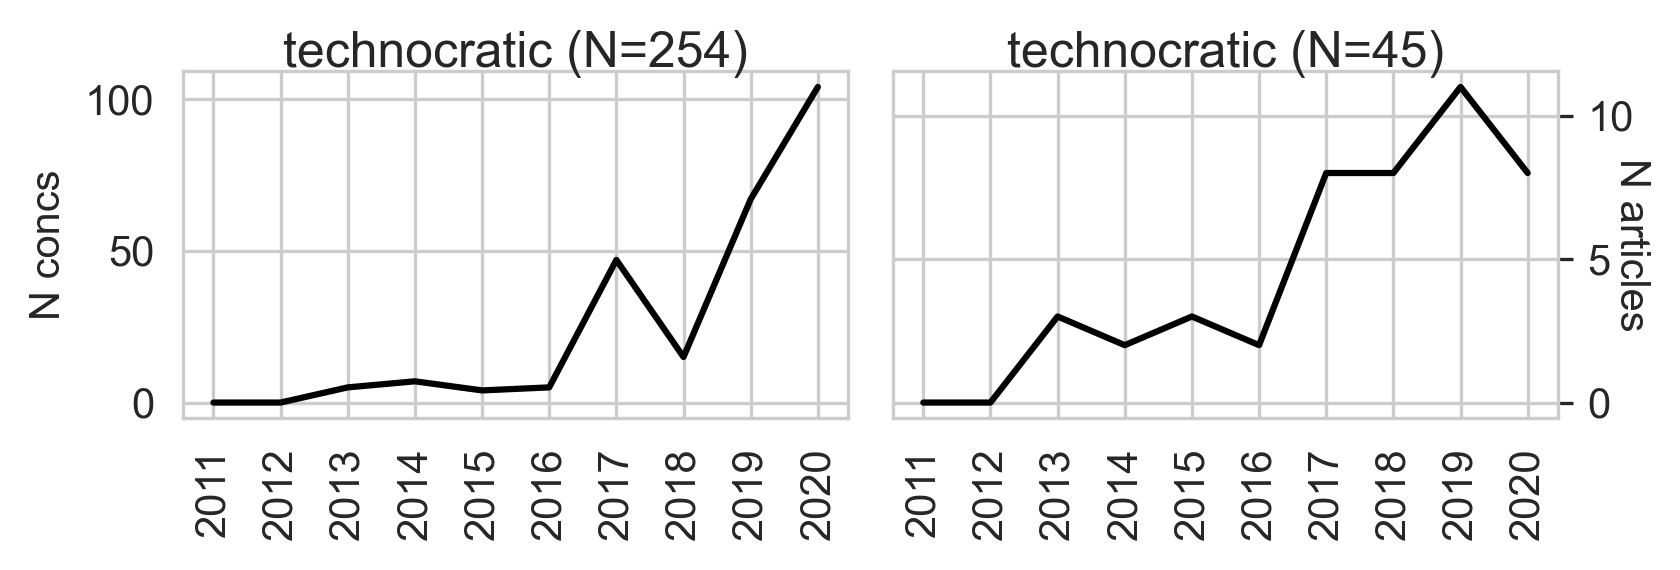

In [114]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(5.7, 2) ,tight_layout=True, dpi=300)
x = range(2011,2021)
y =[(concs_covered_types_tech_df["year"]==str(year)).sum() for year in x]
ax1.plot(x, y ,color="black")
ax1.set_xlabel("")
ax1.set_xticks(range(2011,2021))
ax1.set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
ax1.set_ylabel("N concs")
ax1.set_title("technocratic"  + " (N={})".format(str(len(concs_covered_types_tech_df))), pad=1)

y =[len(set(concs_covered_types_tech_df[concs_covered_types_tech_df["year"]==str(year)]["title"])) for year in x]
ax2.plot(x, y ,color="black")
ax2.set_xlabel("")
ax2.set_xticks(range(2011,2021))
ax2.set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("N articles", rotation=270)
ax2.set_title("technocratic" + " (N={})".format(str(len(set(concs_covered_types_tech_df["title"])))), pad=1)


In [75]:
fig.savefig("../figures/technocratic_counts+articles_years.png")

# Overview of labeled concordances

In [115]:
concs_labeled_df

conc         type  year  \
0     [access, use, find, print, homepage, cite, art...   right-wing  2011   
1     [access, use, find, print, homepage, cite, art...   right-wing  2011   
2     [view, view, relate, article, cite, article, v...   right-wing  2011   
3     [article, cite, article, view, cite, article, ...   right-wing  2011   
4     [success, study, test, assumption, compare, ef...   right-wing  2011   
...                                                 ...          ...   ...   
7910  [contemporary, link, rise, party, european, co...   neoliberal  2015   
7911  [learn, lesson, ideology, style, rhetoric, ide...   neoliberal  2015   
7912  [japanese, discuss, article, need, identify, c...   neoliberal  2015   
7913  [japanese, politic, politic, instance, diverse...   neoliberal  2015   
7914  [learn, need, remember, japanese, politician, ...  nationalist  2015   

                title  
0     Bos et al. 2011  
1     Bos et al. 2011  
2     Bos et al. 2011  
3     Bos et al. 2011  
4     Bos et al. 2011  
...               ...  
7910    Lindgren 2015  
7911    Lindgren 2015  
7912    Lindgren 2015  
7913    Lindgren 2015  
7914    Lindgren 2015  

[7915 rows x 4 columns]

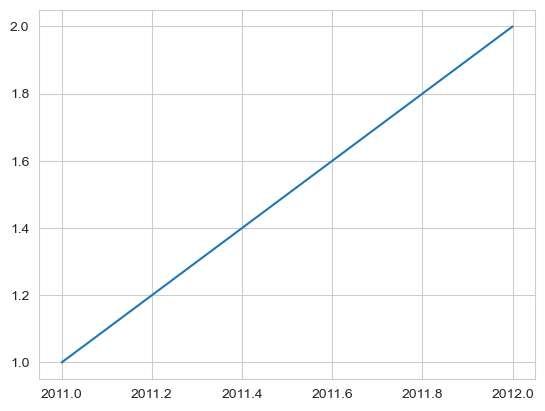

In [116]:
plt.plot([2011,2012], [1,2])


In [117]:
poptype = "nativist"
poptype_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
x = range(2011,2021)
y =[(poptype_df["year"]==str(year)).sum() for year in range(2011,2021)]

Text(0.5, 0, 'year')

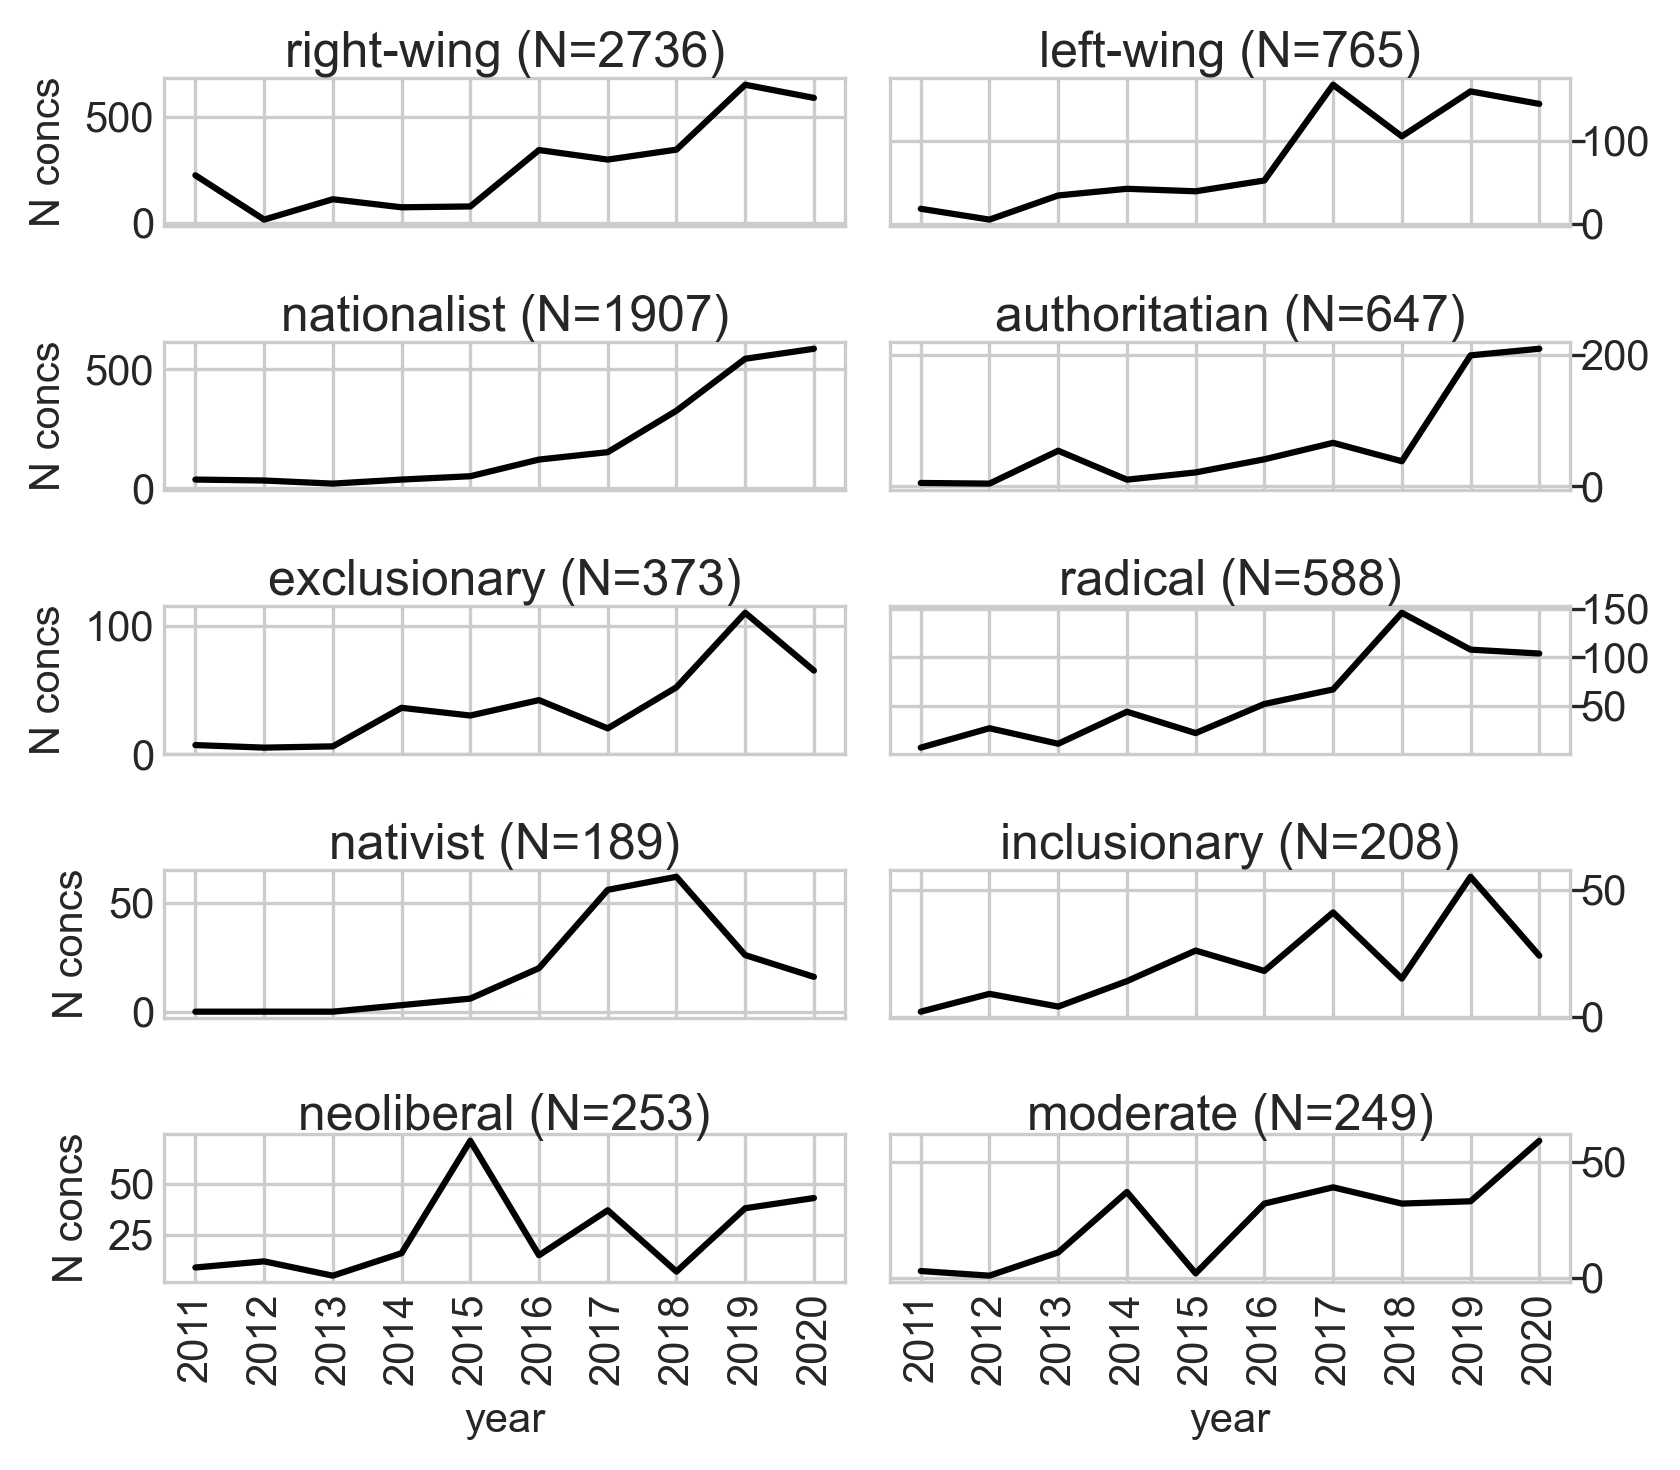

In [118]:
fig, axs = plt.subplots(5,2, figsize=(5.7, 5) ,tight_layout=True, dpi=300)

for poptype, ax, n in zip(poptypes, axs.ravel(), range(len(poptypes))):
    poptype_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    x = range(2011,2021)
    y =[(poptype_df["year"]==str(year)).sum() for year in x]
    ax.plot(x, y ,color="black")
    ax.set_xlabel("")
    ax.set_xticks(range(2011,2021))
    ax.set_xticklabels([])
    if (n % 2) == 0:
        ax.set_ylabel("N concs")
    else:
        ax.yaxis.tick_right()
    ax.set_title(poptype + " (N={})".format(str(len(poptype_df))), pad=1)
    ax.tick_params(axis='both', which='major', pad=-1)



axs[4,0].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,0].set_xlabel("year")

axs[4,1].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,1].set_xlabel("year")

In [136]:
fig.savefig("../figures/poptypes_counts_years.png")

Text(0.5, 0, 'year')

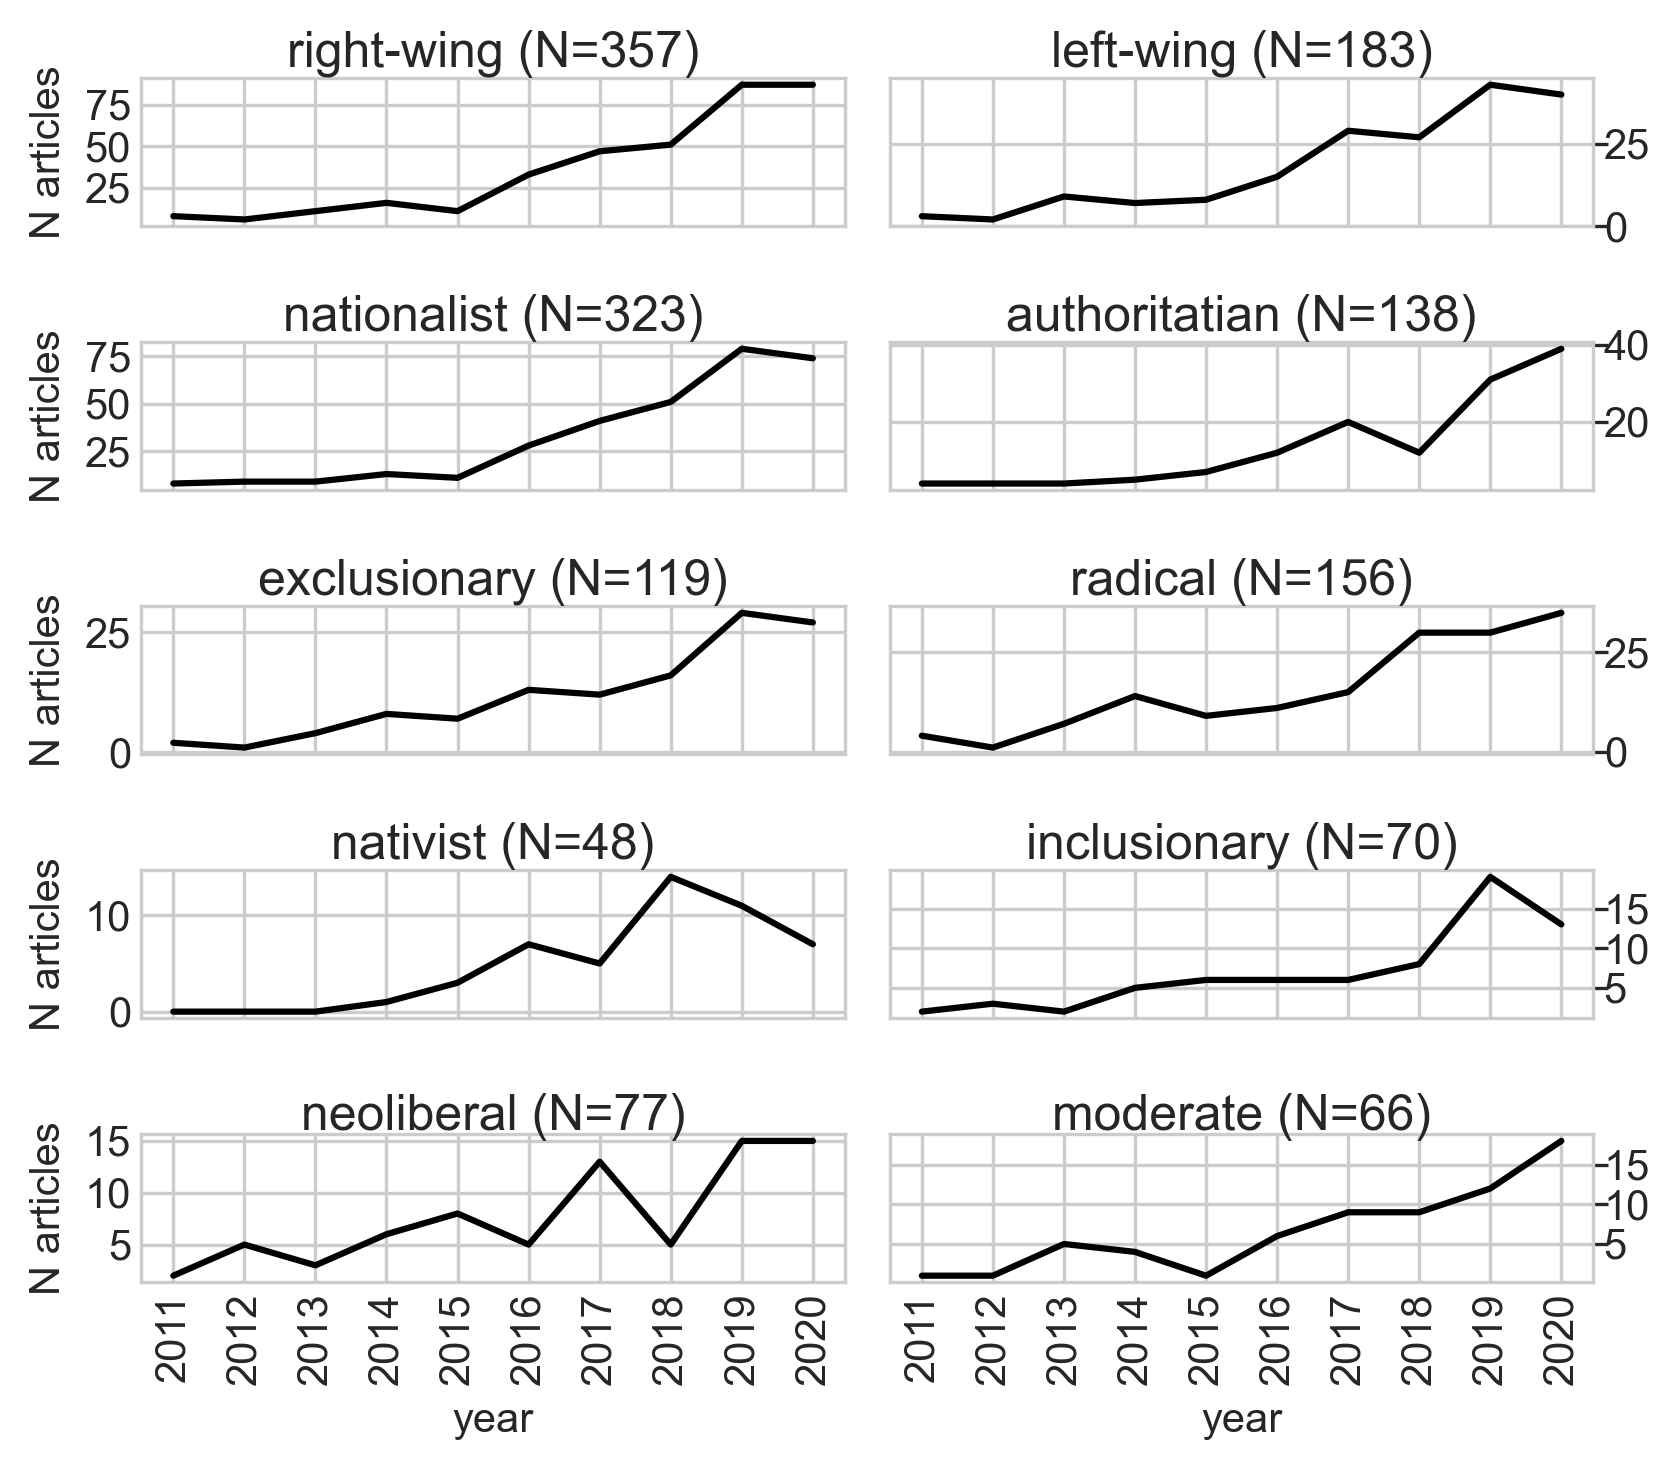

In [119]:
fig, axs = plt.subplots(5,2, figsize=(5.7, 5) ,tight_layout=True, dpi=300)

for poptype, ax, n in zip(poptypes, axs.ravel(), range(len(poptypes))):
    poptype_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    x = range(2011,2021)
    y =[len(set(poptype_df[poptype_df["year"]==str(year)]["title"])) for year in x]
    ax.plot(x, y ,color="black")
    ax.set_xlabel("")
    ax.set_xticks(range(2011,2021))
    ax.set_xticklabels([])
    if (n % 2) == 0:
        ax.set_ylabel("N articles")
    else:
        ax.yaxis.tick_right()
    ax.set_title(poptype + " (N={})".format(str(len(set(poptype_df["title"])))), pad=1)
    ax.tick_params(axis='both', which='major', pad=-1)



axs[4,0].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,0].set_xlabel("year")

axs[4,1].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,1].set_xlabel("year")

In [134]:
fig.savefig("../figures/poptypes_n_articles_years.png")


In [120]:
len(set(poptype_df["title"]))

66

In [121]:
poptype_df_grouped = poptype_df.groupby("year").size()
poptype_df_grouped

year
2011     3
2012     1
2013    11
2014    37
2015     2
2016    32
2017    39
2018    32
2019    33
2020    59
dtype: int64

In [122]:
poptype_df_grouped

year
2011     3
2012     1
2013    11
2014    37
2015     2
2016    32
2017    39
2018    32
2019    33
2020    59
dtype: int64

In [123]:
doc_counts = [len(set(poptype_df[poptype_df["year"]==str(year)]["title"])) for year in range(2011, 2021)]

In [124]:
doc_counts

[1, 1, 5, 4, 1, 6, 9, 9, 12, 18]

# Word explorations

In [126]:
labeled_freqs = nltk.FreqDist([w for conc in concs_labeled_df["conc"] for w in conc]).most_common()
len(labeled_freqs)

9724

In [127]:
to_remove = [tup[0] for tup in labeled_freqs][:5]
to_remove

['party', 'political', 'people', 'democracy', 'politic']

In [128]:
poptype = "left-wing"
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]

def get_freqs_formatted(subset_df, n=100):
    subset_concs_flatten = [w for conc in subset_df["conc"] for w in conc if w not in ["populist", "populism"]]
    total = len(subset_concs_flatten)
    #freqdist_N = [(w + " ({})".format(str(np.round(count/total, 4)))) for w, count in FreqDist(subset_concs_flatten).most_common(n)]
    freqdist_N = [w for w, count in FreqDist(subset_concs_flatten).most_common(n)]
    return freqdist_N

In [129]:
poptypes_wordfreqs_dict = {}
for poptype in poptypes:
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    poptypes_wordfreqs_dict[poptype] = get_freqs_formatted(subset_df, n=100)

In [130]:
poptypes_wordfreqs_df = pd.DataFrame(poptypes_wordfreqs_dict)

In [131]:
poptypes_wordfreqs_df.head(10)

right-wing  left-wing nationalist authoritatian exclusionary     radical  \
0      party      party       party     democracy        party       party   
1  political  political      people     political    political   political   
2     leader    support   political        regime       people   democracy   
3     people   economic     politic         party         case      people   
4    support        new   discourse    democratic      politic     politic   
5  democracy     policy       elite   competitive        elite        case   
6     effect     people       level        leader    democracy         new   
7      study       case   different         power    discourse  democratic   
8      voter   attitude        case       politic     movement    analysis   
9   attitude    politic  government        people        focus    movement   

       nativist inclusionary    neoliberal    moderate  
0         party        party     political       party  
1        people    political         party      effect  
2      movement   democratic      economic    attitude  
3     political       people        policy       level  
4      ideology          way       politic  successful  
5  mobilization    democracy         state        case  
6      economic    discourse        social   political  
7         study     european      ideology       actor  
8       support        group  contemporary     support  
9          case       effect      japanese  government

In [132]:
poptypes_wordfreqs_df.to_csv("../data/poptypes_wordfreqs_df.csv")

In [49]:
google_conf.set_with_dataframe(pop_data.add_worksheet("poptypes_wordfreqs_df", 1,1), poptypes_wordfreqs_df)

In [133]:
poptype = "left-wing"
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]

def get_freqs_vals(subset_df):
    subset_concs_flatten = [w for conc in subset_df["conc"] for w in conc if w not in ["populist", "populism"]]
    total = len(subset_concs_flatten)
    freqdist_N = dict([(w, count/total) for w, count in FreqDist(subset_concs_flatten).most_common()])
    # freqdist_N = [w for w, count in FreqDist(subset_concs_flatten).most_common(n)]
    return freqdist_N

In [134]:
get_freqs_vals(subset_df)

{'party': 0.031091462530801566,
 'political': 0.012538048992607624,
 'support': 0.008117118422959849,
 'economic': 0.007754747064791999,
 'new': 0.006667632990288447,
 'policy': 0.006015364545586317,
 'people': 0.005580518915784896,
 'case': 0.005508044644151326,
 'attitude': 0.005435570372517756,
 'politic': 0.005218147557617046,
 'government': 0.004493404841281345,
 'social': 0.004275982026380635,
 'form': 0.004203507754747065,
 'democracy': 0.004203507754747065,
 'voter': 0.003986084939846354,
 'effect': 0.003986084939846354,
 'election': 0.003913610668212784,
 'leader': 0.0038411363965792145,
 'position': 0.0037686621249456444,
 'discourse': 0.003623713581678504,
 'study': 0.003551239310044934,
 'european': 0.003478765038411364,
 'country': 0.003406290766777794,
 'movement': 0.003406290766777794,
 'ideological': 0.003406290766777794,
 'ideology': 0.003406290766777794,
 'focus': 0.0033338164951442237,
 'rise': 0.0033338164951442237,
 'vote': 0.0033338164951442237,
 'crisis': 0.00318

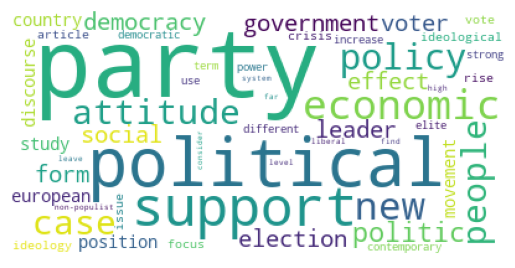

In [135]:
wc = WordCloud(max_words=50, background_color="white", relative_scaling=0.5)
wc.generate_from_frequencies(get_freqs_vals(subset_df))
plt.imshow(wc)  # , interpolation="bilinear")
plt.axis("off")
plt.show()

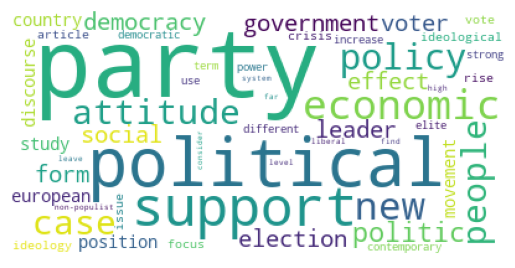

In [136]:
plt.imshow(wc) # , interpolation="bilinear")
plt.axis("off")
plt.show()

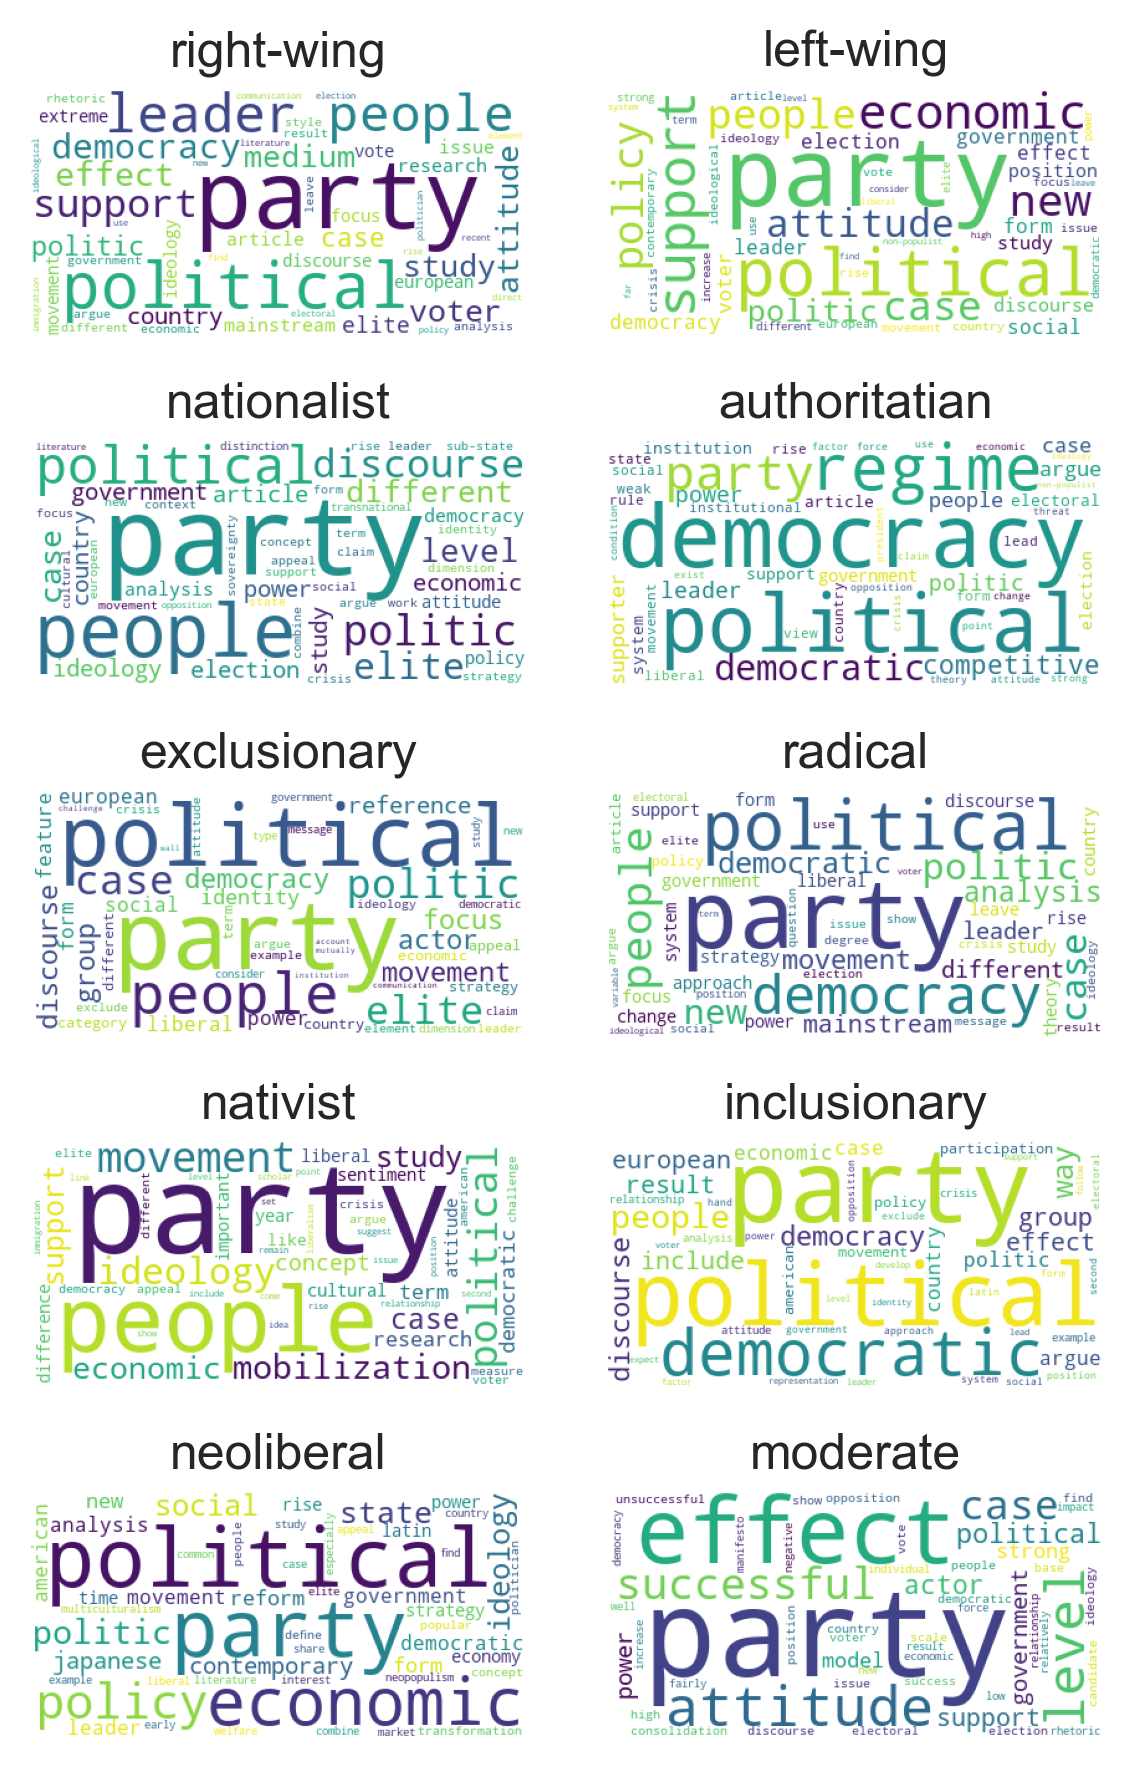

In [137]:
fig, axs = plt.subplots(5,2, figsize=(4,6), dpi=300,tight_layout=True)
for ax, poptype in zip(axs.ravel(), poptypes):
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    wc = WordCloud(max_words=50, background_color="white")
    wc.generate_from_frequencies(get_freqs_vals(subset_df))
    ax.imshow(wc) # , interpolation="bilinear")
    ax.axis("off")
    ax.set_title(poptype)

In [138]:
freqs_vals_dict = {}
for poptype in poptypes:
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    freqs_vals_dict[poptype] = get_freqs_vals(subset_df)
freqs_vals_df = pd.DataFrame(freqs_vals_dict).fillna(0)
freqs_vals_df[1500:1510]

right-wing  left-wing  nationalist  authoritatian  \
paradoxical      0.000122   0.000000     0.000000       0.000000   
constituent      0.000122   0.000290     0.000146       0.001720   
classiﬁcation    0.000122   0.000000     0.000146       0.000086   
heterogeneity    0.000122   0.000000     0.000088       0.000086   
teach            0.000122   0.000000     0.000029       0.000258   
rightly          0.000122   0.000000     0.000058       0.000086   
grassroot        0.000122   0.000145     0.000058       0.000430   
aﬃnity           0.000122   0.000000     0.000058       0.000000   
extraordinary    0.000102   0.000000     0.000175       0.000172   
adhere           0.000102   0.000072     0.000175       0.000000   

               exclusionary   radical  nativist  inclusionary  neoliberal  \
paradoxical        0.000000  0.000094       0.0      0.000000         0.0   
constituent        0.000149  0.000657       0.0      0.000000         0.0   
classiﬁcation      0.000149  0.000094       0.0      0.000000         0.0   
heterogeneity      0.000000  0.000094       0.0      0.000264         0.0   
teach              0.000000  0.000000       0.0      0.000000         0.0   
rightly            0.000000  0.000188       0.0      0.000000         0.0   
grassroot          0.000000  0.000094       0.0      0.000264         0.0   
aﬃnity             0.000000  0.000000       0.0      0.000000         0.0   
extraordinary      0.000000  0.000094       0.0      0.000264         0.0   
adhere             0.000000  0.000281       0.0      0.000000         0.0   

               moderate  
paradoxical    0.000000  
constituent    0.000455  
classiﬁcation  0.000000  
heterogeneity  0.000455  
teach          0.000000  
rightly        0.000000  
grassroot      0.000000  
aﬃnity         0.000000  
extraordinary  0.000000  
adhere         0.000000

In [139]:
freqs_cossim = pd.DataFrame(cosine_similarity(freqs_vals_df.T).round(2), columns=poptypes, index=poptypes)
freqs_cossim

right-wing  left-wing  nationalist  authoritatian  \
right-wing           1.00       0.92         0.83           0.66   
left-wing            0.92       1.00         0.84           0.67   
nationalist          0.83       0.84         1.00           0.72   
authoritatian        0.66       0.67         0.72           1.00   
exclusionary         0.81       0.81         0.87           0.68   
radical              0.92       0.91         0.83           0.70   
nativist             0.75       0.75         0.77           0.60   
inclusionary         0.80       0.82         0.81           0.70   
neoliberal           0.68       0.76         0.75           0.64   
moderate             0.82       0.80         0.68           0.52   

               exclusionary  radical  nativist  inclusionary  neoliberal  \
right-wing             0.81     0.92      0.75          0.80        0.68   
left-wing              0.81     0.91      0.75          0.82        0.76   
nationalist            0.87     0.83      0.77          0.81        0.75   
authoritatian          0.68     0.70      0.60          0.70        0.64   
exclusionary           1.00     0.82      0.74          0.80        0.70   
radical                0.82     1.00      0.74          0.82        0.72   
nativist               0.74     0.74      1.00          0.70        0.64   
inclusionary           0.80     0.82      0.70          1.00        0.71   
neoliberal             0.70     0.72      0.64          0.71        1.00   
moderate               0.65     0.77      0.63          0.70        0.53   

               moderate  
right-wing         0.82  
left-wing          0.80  
nationalist        0.68  
authoritatian      0.52  
exclusionary       0.65  
radical            0.77  
nativist           0.63  
inclusionary       0.70  
neoliberal         0.53  
moderate           1.00

# Weighted frequencies
(an alternative to tf-idf)

In [140]:
labeled_freqs = nltk.FreqDist([w for conc in concs_labeled_df["conc"] for w in conc]).most_common()
total_count = sum([tup[1] for tup in labeled_freqs])
labeled_freqs = [(tup[0], tup[1] / total_count) for tup in labeled_freqs]
labeled_freqs_dict = dict(labeled_freqs)

In [141]:
labeled_freqs_dict

{'party': 0.027207247763209725,
 'political': 0.012858027122840582,
 'people': 0.008595464520848573,
 'democracy': 0.006203927747453717,
 'politic': 0.005859265094817399,
 'leader': 0.0053035844915874176,
 'case': 0.004944853975578189,
 'support': 0.0049167182488323675,
 'discourse': 0.0043118001237971975,
 'attitude': 0.0041570536266951775,
 'economic': 0.00404451071971189,
 'elite': 0.004009341061279613,
 'effect': 0.00396713747116088,
 'study': 0.0039108660176692366,
 'country': 0.0038053570423724043,
 'government': 0.0037772213156265825,
 'movement': 0.003509931911541275,
 'article': 0.0034255247313038097,
 'ideology': 0.003411456867930899,
 'power': 0.003369253277812166,
 'policy': 0.0033481514827527997,
 'democratic': 0.003334083619379889,
 'different': 0.0032145067807101456,
 'analysis': 0.0031652692589049574,
 'voter': 0.0031230656687862247,
 'new': 0.0031160317370997693,
 'argue': 0.003108997805413314,
 'election': 0.00305272635192167,
 'european': 0.0028839119914467392,
 'lev

In [142]:
overall_freqs = freqs_vals_df.reset_index()["index"].apply(lambda x: labeled_freqs_dict[x])
freqs_vals_df["overall_freqs"]  = overall_freqs.round(6).tolist()

In [143]:
freqs_vals_df.sort_values("overall_freqs", ascending=False, inplace=True)

In [144]:
freqs_vals_df

right-wing  left-wing  nationalist  authoritatian  exclusionary  \
party           0.036862   0.031091     0.016901       0.010317      0.021346   
political       0.012226   0.012538     0.012260       0.013498      0.016271   
people          0.007776   0.005581     0.012931       0.005674      0.014032   
democracy       0.006327   0.004204     0.003561       0.016164      0.005523   
politic         0.004817   0.005218     0.007794       0.006448      0.006120   
...                  ...        ...          ...            ...           ...   
demobilizing    0.000000   0.000000     0.000029       0.000000      0.000000   
tacit           0.000000   0.000000     0.000029       0.000000      0.000000   
colonel         0.000000   0.000000     0.000029       0.000000      0.000000   
pueblo          0.000000   0.000000     0.000029       0.000000      0.000000   
backstoppe      0.000000   0.000000     0.000000       0.000000      0.000000   

               radical  nativist  inclusionary  neoliberal  moderate  \
party         0.036773  0.018535      0.021946    0.015835  0.041146   
political     0.015666  0.007944      0.015600    0.017374  0.008638   
people        0.006473  0.008826      0.007932    0.003079  0.004092   
democracy     0.010038  0.003530      0.005817    0.002419  0.003410   
politic       0.006473  0.002059      0.005024    0.009017  0.001364   
...                ...       ...           ...         ...       ...   
demobilizing  0.000000  0.000000      0.000000    0.000000  0.000000   
tacit         0.000000  0.000000      0.000000    0.000000  0.000000   
colonel       0.000000  0.000000      0.000000    0.000000  0.000000   
pueblo        0.000000  0.000000      0.000000    0.000000  0.000000   
backstoppe    0.000000  0.000000      0.000000    0.000000  0.000227   

              overall_freqs  
party              0.027207  
political          0.012858  
people             0.008595  
democracy          0.006204  
politic            0.005859  
...                     ...  
demobilizing       0.000007  
tacit              0.000007  
colonel            0.000007  
pueblo             0.000007  
backstoppe         0.000007  

[9724 rows x 11 columns]

In [145]:
freqs_vals_weighted_df = pd.DataFrame()
for poptype in poptypes:
    freqs_vals_weighted_df[poptype] = freqs_vals_df.apply(lambda row: row[poptype] / row["overall_freqs"], axis=1)

In [146]:
#freqs_vals_weighted_df = freqs_vals_weighted_df / freqs_vals_weighted_df.max()

In [147]:
poptype = "left-wing"
s = freqs_vals_weighted_df[poptype]
s_norm = s.apply(lambda x: ((x / s.max()) + 1) / 2)
s_norm

party           0.555188
political       0.547091
people          0.531355
democracy       0.532721
politic         0.543011
                  ...   
demobilizing    0.500000
tacit           0.500000
colonel         0.500000
pueblo          0.500000
backstoppe      0.500000
Name: left-wing, Length: 9724, dtype: float64

In [148]:
cmap = matplotlib.cm.get_cmap('Greys')

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_40496/2269090756.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greys')


In [149]:
matplotlib.colors.to_hex(cmap(s_norm["attitude"]))

'#848484'

In [150]:
cmap = matplotlib.cm.get_cmap('Greys')
s = freqs_vals_weighted_df[poptype]
s_norm = s.apply(lambda x: ((x / s.max()) + 1) / 2)
def image_colors(word, font_size, position, orientation, random_state, font_path):
    color = matplotlib.colors.to_hex(cmap(s_norm[word]))
    return color

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_40496/3432939036.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greys')


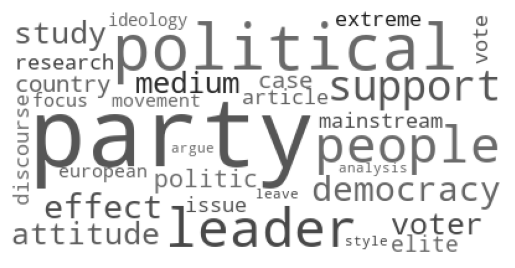

In [151]:
poptype = "right-wing"
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
s = freqs_vals_weighted_df[poptype]
s_norm = s.apply(lambda x: ((x / s.max()) + 1) / 2)
wc = WordCloud(max_words=30, background_color="white", relative_scaling=0.5)
wc.generate_from_frequencies(get_freqs_vals(subset_df))
wc.recolor(color_func=image_colors)
plt.imshow(wc)  # , interpolation="bilinear")
plt.axis("off")
plt.show()

In [152]:
dict([el for el in get_freqs_vals(subset_df).items()][5:])

{'democracy': 0.006327305384332776,
 'effect': 0.006000734783851084,
 'study': 0.00506184430746622,
 'voter': 0.005021022982406009,
 'attitude': 0.00491896966975548,
 'medium': 0.0048781483446952685,
 'politic': 0.004816916357104952,
 'case': 0.004551577744213577,
 'country': 0.00449034575662326,
 'elite': 0.003939257868310405,
 'mainstream': 0.0038576152181899826,
 'issue': 0.003816793893129771,
 'article': 0.0037759725680695595,
 'research': 0.003571865942768502,
 'discourse': 0.003571865942768502,
 'extreme': 0.0034085806425276565,
 'vote': 0.003347348654937339,
 'european': 0.003286116667347022,
 'movement': 0.003286116667347022,
 'focus': 0.003224884679756705,
 'ideology': 0.003204474017226599,
 'analysis': 0.0031840633546964935,
 'style': 0.003143242029636282,
 'argue': 0.003122831367106176,
 'leave': 0.003122831367106176,
 'rhetoric': 0.0031024207045760705,
 'government': 0.003000367391925542,
 'different': 0.002979956729395436,
 'result': 0.0029187247418051188,
 'economic': 0.0

In [153]:
import nltk

In [154]:
to_remove = [tup[0] for tup in nltk.FreqDist([w for conc in concs_labeled_df["conc"] for w in conc]).most_common(5)]
to_remove

['party', 'political', 'people', 'democracy', 'politic']

In [155]:
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
subset_df

conc        type  year  \
0     [access, use, find, print, homepage, cite, art...  right-wing  2011   
1     [access, use, find, print, homepage, cite, art...  right-wing  2011   
2     [view, view, relate, article, cite, article, v...  right-wing  2011   
3     [article, cite, article, view, cite, article, ...  right-wing  2011   
4     [success, study, test, assumption, compare, ef...  right-wing  2011   
...                                                 ...         ...   ...   
7889  [particular, time, period, dominate, argument,...  right-wing  2015   
7892  [post-material, value, propose, series, public...  right-wing  2015   
7893  [point, research, show, party, adopt, frame, p...  right-wing  2015   
7895  [differ, ideological, view, maybe, deserve, de...  right-wing  2015   
7908  [correct, vague, anxiety, new, perception, pol...  right-wing  2015   

                title  
0     Bos et al. 2011  
1     Bos et al. 2011  
2     Bos et al. 2011  
3     Bos et al. 2011  
4     Bos et al. 2011  
...               ...  
7889    Lindgren 2015  
7892    Lindgren 2015  
7893    Lindgren 2015  
7895    Lindgren 2015  
7908    Lindgren 2015  

[2736 rows x 4 columns]

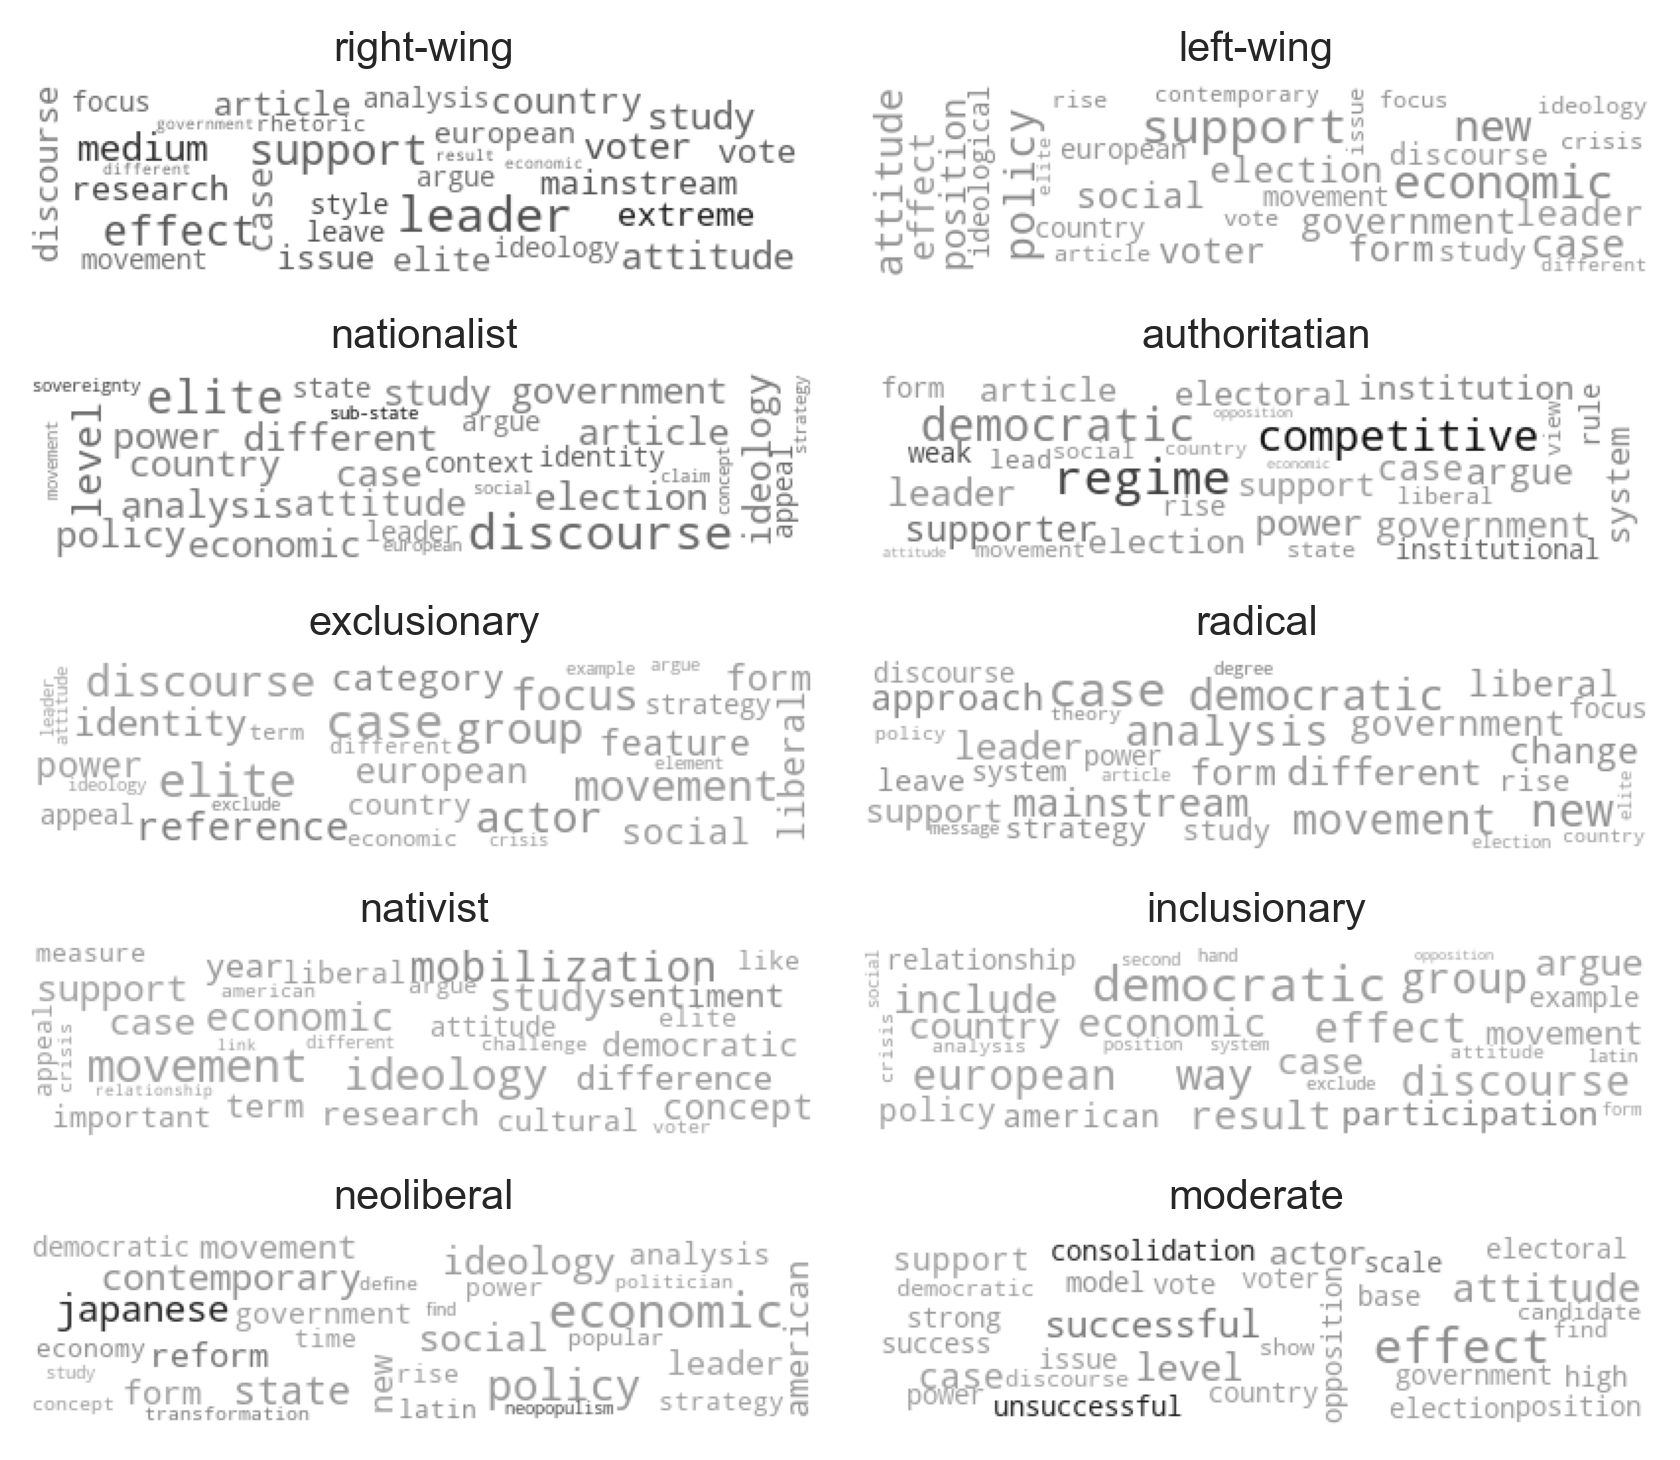

In [156]:
fig, axs = plt.subplots(5,2, figsize=(5.7,5), dpi=300,tight_layout=True)
for ax, poptype in zip(axs.ravel(), poptypes):
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    s = freqs_vals_weighted_df[poptype]
    s_norm = s.apply(lambda x: ((x / s.max()) + 0.8) / 1.8)
    wc = WordCloud(max_words=30, background_color="white", width=400, height=100, max_font_size=25)
    freqs = dict([el for el in get_freqs_vals(subset_df).items() if el[0] not in to_remove])
    wc.generate_from_frequencies(freqs)
    wc.recolor(color_func=image_colors)
    ax.imshow(wc) # , interpolation="bilinear")
    ax.axis("off")
    ax.set_title(poptype, size=10)

In [188]:
fig.savefig("../figures/wordcloud_v1.png")

# Exploring "Japanise" in neoliberal and "competitive" and "regime" in authoritatian

In [161]:
concs_labeled_df[(concs_labeled_df["type"]=="neoliberal") & concs_labeled_df["conc"].apply(lambda x: "japanese" in x)]

conc        type  year  \
7856  [politician, see, representative, wave, japane...  neoliberal  2015   
7857  [political, system, examine, existence, ﬁnd, j...  neoliberal  2015   
7858  [examine, existence, ﬁnd, japanese, politic, s...  neoliberal  2015   
7859  [ﬁnd, japanese, politic, see, variant, interes...  neoliberal  2015   
7860  [interest-led, popyurizumu, develop, argument,...  neoliberal  2015   
7872  [reform, fundamental, mix, ideology, accord, a...  neoliberal  2015   
7873  [matter, conservative, stress, tradition, stat...  neoliberal  2015   
7874  [conservative, stress, tradition, state, contr...  neoliberal  2015   
7896  [structural, element, deﬁne, party, family, in...  neoliberal  2015   
7900  [suggestion, substantiate, fact, independent, ...  neoliberal  2015   
7901  [fact, independent, mayor, governor, table, ou...  neoliberal  2015   
7902  [table, outline, potential, ﬁve, ideology, fin...  neoliberal  2015   
7903  [ideology, find, literature, japanese, focus, ...  neoliberal  2015   
7904  [come, welfare-oriented, example, welfare, ori...  neoliberal  2015   
7905  [welfare, orientation, combine, anti-bureaucra...  neoliberal  2015   
7906  [anti-bureaucratic, stance, example, anti-bure...  neoliberal  2015   
7907  [share, japanese, include, insight, point, ide...  neoliberal  2015   
7912  [japanese, discuss, article, need, identify, c...  neoliberal  2015   
7913  [japanese, politic, politic, instance, diverse...  neoliberal  2015   

              title  
7856  Lindgren 2015  
7857  Lindgren 2015  
7858  Lindgren 2015  
7859  Lindgren 2015  
7860  Lindgren 2015  
7872  Lindgren 2015  
7873  Lindgren 2015  
7874  Lindgren 2015  
7896  Lindgren 2015  
7900  Lindgren 2015  
7901  Lindgren 2015  
7902  Lindgren 2015  
7903  Lindgren 2015  
7904  Lindgren 2015  
7905  Lindgren 2015  
7906  Lindgren 2015  
7907  Lindgren 2015  
7912  Lindgren 2015  
7913  Lindgren 2015

In [162]:
articles_metadata[articles_metadata["working_title"]=="Lindgren 2015"]

pop_id  year   authors                                journal  \
540     540  2015  Lindgren  Japanese Journal of Political Science   

                                                 title     type  \
540  Developing Japanese Populism Research through ...  article   

                                              filepath  working_title  
540  Japanese Journal of Political Science/2015 - L...  Lindgren 2015

In [166]:
competitive_df = concs_labeled_df[(concs_labeled_df["type"]=="authoritatian") & concs_labeled_df["conc"].apply(lambda x: "competitive" in x)]
competitive_df

conc           type  year  \
486   [history, lure, song, personalistic, plebiscit...  authoritatian  2013   
487   [political, emphasize, friend, entrench, predo...  authoritatian  2013   
597   [view, democratization, illiberal, plebiscitar...  authoritatian  2018   
598   [encounter, crisis, react, move, competitive, ...  authoritatian  2018   
599   [democracy, end, civil, society, democratic, i...  authoritatian  2018   
600   [unchecked, tend, establishment, competitive, ...  authoritatian  2018   
601   [autocrat, giant, foot, control, appear, undis...  authoritatian  2018   
602   [electoral, defeat, subsequent, peaceful, hand...  authoritatian  2018   
603   [handover, power, possible, happen, presidency...  authoritatian  2018   
714   [advent, competitive, rule, case, aptly, illus...  authoritatian  2020   
769   [real, political, change, devise, strategy, ap...  authoritatian  2020   
770   [leader, competitive, regime, argue, employ, d...  authoritatian  2020   
1698  [people, online, voting, policy, deliberation,...  authoritatian  2020   
1699  [expression, general, people, ideational, appr...  authoritatian  2020   
1700  [approach, allow, scholar, begin, cross-nation...  authoritatian  2020   
1702  [endurance, competitive, state, interestingly,...  authoritatian  2020   
1721  [immediately, dub, coup, relevance, breakdown,...  authoritatian  2020   
1722  [possibility, victory, lead, directly, competi...  authoritatian  2020   
1723  [case, claim, successful, frequently, lead, co...  authoritatian  2020   
1848  [way, download, subject, term, use, available,...  authoritatian  2020   
2041  [playing, ﬁeld, finally, analyse, electoral, r...  authoritatian  2019   
2043  [military, intervention, election, critical, p...  authoritatian  2019   
2046  [medium, outlet, propagate, electoral, strateg...  authoritatian  2019   
2330  [modern, democracy, mixed, regime, combine, ol...  authoritatian  2019   
2331  [combine, oligarchy, democracy, provide, mecha...  authoritatian  2019   
2332  [elucidate, particular, path, competitive, set...  authoritatian  2019   
2333  [find, source, imaginative, appeal, practice, ...  authoritatian  2019   
2334  [source, imaginative, appeal, practice, mixed,...  authoritatian  2019   
2335  [place, perennial, potential, modern, democrac...  authoritatian  2019   
2339  [lead, opposite, original, claim, reflect, pop...  authoritatian  2019   
2340  [sacralization, ensue, singularization, ultima...  authoritatian  2019   
2347  [mainly, trigger, aspect, modern, democratic, ...  authoritatian  2019   
2503  [access, use, find, print, homepage, competiti...  authoritatian  2013   
2504  [emerge, postcold, period, article, seek, expl...  authoritatian  2013   
2505  [slide, competitive, argument, demonstrate, co...  authoritatian  2013   
2506  [email, explain, emergence, argue, primary, ca...  authoritatian  2013   
2507  [causal, mechanism, link, democratic, breakdow...  authoritatian  2013   
2508  [understand, argue, government, push, weak, de...  authoritatian  2013   
2509  [party, decay, competitive, additional, factor...  authoritatian  2013   
2510  [competitive, additional, factor, trigger, tra...  authoritatian  2013   
2514  [marginalize, group, inﬂuential, position, adv...  authoritatian  2013   
2515  [group, time, tend, push, weak, democracy, com...  authoritatian  2013   
2517  [likely, competitive, back, referendum, victor...  authoritatian  2013   
2518  [institution, impose, new, constitutional, rul...  authoritatian  2013   
2519  [state, apparatus, little, difﬁculty, skew, pl...  authoritatian  2013   
2520  [play, ﬁeld, opponent, relationship, competiti...  authoritatian  2013   
2521  [ﬁeld, opponent, relationship, competitive, st...  authoritatian  2013   
2522  [prevent, executive, attack, establish, party,...  authoritatian  2013   
2523  [cause, competitive, raise, question, relation...  authoritatian  2013   
2524  [question, relationship, spurious, additional

In [169]:
competitive_grouped_df = competitive_df.groupby("title").size().sort_values(ascending=False).reset_index()
competitive_grouped_df

title   0
0           Levitsky, Loxton 2013  48
1                      Sozen 2019   9
2                        Art 2020   7
3                de la Torre 2018   7
4   Stavrakakis, Katsambekis 2014   3
5                      Sözen 2019   3
6                de la Torre 2016   3
7             Peters, Pierre 2020   2
8                    Weyland 2013   2
9          Wuthrich, Ingleby 2020   2
10     Aslanidis, Kaltwasser 2016   1
11      Marcos-Marne et al. 2020b   1
12                     Raisi 2019   1
13                   Weyland 2020   1
14      de Lara, de la Torre 2020   1

In [170]:
articles_metadata[articles_metadata["working_title"].isin(competitive_grouped_df["title"])]

pop_id  year                   authors  \
32       32  2013                   Weyland   
50       50  2018               de la Torre   
66       66  2020      de Lara, de la Torre   
76       76  2020         Wuthrich, Ingleby   
133     133  2020                       Art   
136     136  2020                   Weyland   
146     146  2019                     Sözen   
164     164  2019                     Sozen   
176     176  2013          Levitsky, Loxton   
178     178  2016     Aslanidis, Kaltwasser   
190     190  2019                     Raisi   
193     193  2020            Peters, Pierre   
328     328  2020       Marcos-Marne et al.   
422     422  2014  Stavrakakis, Katsambekis   
425     425  2016               de la Torre   

                                 journal  \
32                  Journal of Democracy   
50                  Journal of Democracy   
66                  Journal of Democracy   
76                  Journal of Democracy   
133             Perspectives on Politics   
136             Perspectives on Politics   
146  South European Society and Politics   
164             Political Studies Review   
176                      Democratization   
178                      Democratization   
190                      Democratization   
193                      Democratization   
328                    Electoral Studies   
422      Journal of Political Ideologies   
425      Journal of Political Ideologies   

                                                 title     type  \
32   Latin America’s Authoritarian Drift: The Threa...  article   
50   Latin America’s Shifting Politics: Ecuador Aft...  article   
66   The Pushback Against Populism: Why Ecuador’s R...  article   
76   The Pushback Against Populism: Running on “Rad...  article   
133                        The Myth of Global Populism  article   
136  Populism’s Threat to Democracy: Comparative Le...  article   
146  Competition in a Populist Authoritarian Regime...  article   
164  Populist Peril to Democracy: The Sacralization...  article   
176  Populism and competitive authoritarianism in t...  article   
178  Dealing with populists in government: the SYRI...  article   
190  The puzzle of populism in Iran’s electoral pol...  article   
193  A typology of populism: understanding the diff...  article   
328  Is populism the third dimension? The quest for...  article   
422  Left-wing populism in the European periphery: ...  article   
425  Populism and the politics of the extraordinary...  article   

                                              filepath  \
32   Journal of Democracy/2013 - Weyland - Latin Am...   
50   Journal of Democracy/2018 - De la Torre - Lati...   
66   Journal of Democracy/2020 - de Lara, de la Tor...   
76   Journal of Democracy/2020 - Wuthrich, Ingleby ...   
133  Perspectives on Politics/2020 - Art - The Myth...   
136  Perspectives on Politics/2020 - Weyland - Popu...   
146  South European Society and Politics/2019 - Sö...   
164  Political Studies Review/2019 - Sozen - Populi...   
176  Democratization/2013 - Levitsky, Loxton - Popu...   
178  Democratization/2016 - Aslanidis, Kaltwasser -...   
190  Democratization/2019 - Raisi - The puzzle of p...   
193  Democratization/2020 - Peters, Pierre - A typo...   
328  Electoral Studies/2020 - Marcos-Marne et al. -...   
422  Journal of Political Ideologies/2014 - Stavrak...   
425  Journal of Political Ideologies/2016 - de la T...   

                     working_title  
32                    Weyland 2013  
50                de la Torre 2018  
66       de Lara, de la Torre 2020  
76          Wuthrich, Ingleby 2020  
133                       Art 2020  
136                   Weyland 2020  
146                     Sözen 2019  
164                     Sozen 2019  
176          Levitsky, Loxton 2013  
178     Aslanidis, Kaltwasser 2016  
190                     Raisi 2019  
193            Peters, Pierre 2020  
328      Marcos-Marne et al. 2020b  
422  Stavrakakis, Katsambek

In [172]:
regime_df = concs_labeled_df[
    (concs_labeled_df["type"] == "authoritatian") & concs_labeled_df["conc"].apply(lambda x: "regime" in x)]
regime_df

conc           type  year  \
472   [highlight, transition, democracy, southern, r...  authoritatian  2012   
486   [history, lure, song, personalistic, plebiscit...  authoritatian  2013   
487   [political, emphasize, friend, entrench, predo...  authoritatian  2013   
558   [modern, façade, choice, decorum, fervor, fit,...  authoritatian  2017   
602   [electoral, defeat, subsequent, peaceful, hand...  authoritatian  2018   
603   [handover, power, possible, happen, presidency...  authoritatian  2018   
769   [real, political, change, devise, strategy, ap...  authoritatian  2020   
770   [leader, competitive, regime, argue, employ, d...  authoritatian  2020   
1541  [political, institutional, dimension, activate...  authoritatian  2019   
1542  [dimension, activate, similar, ideology, direc...  authoritatian  2019   
1680  [insurgency, american, politic, consider, pros...  authoritatian  2019   
1681  [racially, divisive, party, politic, entrenche...  authoritatian  2019   
1828  [clear, tendency, chief, executive, fact, stra...  authoritatian  2020   
1845  [democracy, conceive, term, interchangeably, l...  authoritatian  2020   
1846  [liberal, pluralism, danger, root, nature, ana...  authoritatian  2020   
1847  [danger, root, nature, analysis, regime, impac...  authoritatian  2020   
2037  [access, use, find, print, homepage, regime, c...  authoritatian  2019   
2038  [use, find, print, homepage, regime, cite, art...  authoritatian  2019   
2039  [article, view, view, relate, article, datum, ...  authoritatian  2019   
2040  [regime, ABSTRACT, article, examine, president...  authoritatian  2019   
2043  [military, intervention, election, critical, p...  authoritatian  2019   
2045  [popular, go, start, work, potent, way, sum, p...  authoritatian  2019   
2046  [medium, outlet, propagate, electoral, strateg...  authoritatian  2019   
2059  [system, recent, memory, regime, lack, profess...  authoritatian  2020   
2270  [government, respect, legal, institutional, co...  authoritatian  2018   
2271  [redistribution, democratic, non-populist, gov...  authoritatian  2018   
2272  [autocracy, identiﬁed, datum, set, regime, cla...  authoritatian  2018   
2273  [important, argue, nature, previous, regime, d...  authoritatian  2018   
2279  [democracy, regime, identiﬁed, classiﬁcation, ...  authoritatian  2018   
2280  [identiﬁed, datum, set, regime, classiﬁe, demo...  authoritatian  2018   
2281  [set, regime, classiﬁe, democratic, classiﬁe, ...  authoritatian  2018   
2282  [autogolpe, non-populist, autocracy, non-popul...  authoritatian  2018   
2330  [modern, democracy, mixed, regime, combine, ol...  authoritatian  2019   
2332  [elucidate, particular, path, competitive, set...  authoritatian  2019   
2333  [find, source, imaginative, appeal, practice, ...  authoritatian  2019   
2334  [source, imaginative, appeal, practice, mixed,...  authoritatian  2019   
2338  [predicate, conceptualization, modern, democra...  authoritatian  2019   
2341  [democracy, oligarchy, possible, single, insti...  authoritatian  2019   
2347  [mainly, trigger, aspect, modern, democratic, ...  authoritatian  2019   
2354  [democracy, contain, institution, modern, demo...  authoritatian  2019   
2355  [legacy, previous, hybrid, political, regime, ...  authoritatian  2019   
2530  [opposition, de, consider, form, hybrid, regim...  authoritatian  2013   
2531  [statismc, regime, outcome, yes, yes, competit...  authoritatian  2013   
2532  [continue, economic, crisisa, potentialb, stat...  authoritatian  2013   
2533  [potentialb, statismc, regime, outcome, democr...  authoritatian  2013   
2534  [politician, personalistic, run, president, pa...  authoritatian  2013   
2535  [personalistic, run, president, party, found, ...  authoritatian  2013   
2536  [president, party, found, dominate, measure, c...  authoritatian  2013   
2563  [govern, democratically, despite, economic, cr...  authoritatian  2013   
2564  [beneﬁte, mineral, boom, institutional, basis

In [175]:
regime_grouped_df = regime_df.groupby("title").size().sort_values(ascending=False).reset_index()
regime_grouped_df

title   0
0             Peters, Pierre 2020  12
1            Robinson, Milne 2017   9
2                      Sozen 2019   9
3           Levitsky, Loxton 2013   9
4               Houle, Kenny 2018   8
5                       Miao 2020   8
6                      Sözen 2019   7
7                      Raisi 2019   4
8                    Weyland 2020   4
9                      Kenny 2020   3
10                   Yabanci 2020   2
11         Wuthrich, Ingleby 2020   2
12                   Weyland 2013   2
13                     Surel 2019   2
14                   Salgado 2019   2
15     Rogenhofer, Panievsky 2020   2
16               de la Torre 2018   2
17                       Lee 2019   2
18                   Győrffy 2020   2
19             Colburn, Cruz 2012   1
20          Rupnik, Zielonka 2013   1
21       Hadiz, Chryssogelos 2017   1
22  Santana-Pereira, Cancela 2020   1
23       Seghezza, Pittaluga 2018   1
24                Guan, Yang 2020   1
25                   Grdešić 2017   1
26                     Grant 2019   1
27                 Goldstein 2018   1
28                      Fish 2018   1
29                      Fish 2017   1
30               de la Torre 2016   1
31     Aslanidis, Kaltwasser 2016   1

In [177]:
articles_metadata[articles_metadata["working_title"].isin(regime_grouped_df["title"])]

pop_id  year                   authors  \
26       26  2012             Colburn, Cruz   
32       32  2013                   Weyland   
41       41  2017                      Fish   
50       50  2018               de la Torre   
76       76  2020         Wuthrich, Ingleby   
119     119  2019                     Surel   
132     132  2019                       Lee   
136     136  2020                   Weyland   
146     146  2019                     Sözen   
148     148  2020  Santana-Pereira, Cancela   
161     161  2018              Houle, Kenny   
164     164  2019                     Sozen   
176     176  2013          Levitsky, Loxton   
178     178  2016     Aslanidis, Kaltwasser   
190     190  2019                     Raisi   
193     193  2020            Peters, Pierre   
194     194  2020     Rogenhofer, Panievsky   
219     219  2020                     Kenny   
287     287  2018       Seghezza, Pittaluga   
311     311  2017                   Grdešić   
313     313  2020                   Győrffy   
331     331  2017       Hadiz, Chryssogelos   
335     335  2017           Robinson, Milne   
375     375  2018                      Fish   
382     382  2019                   Salgado   
389     389  2020                      Miao   
399     399  2013          Rupnik, Zielonka   
425     425  2016               de la Torre   
444     444  2020                Guan, Yang   
454     454  2018                 Goldstein   
483     483  2019                     Grant   
492     492  2020                   Yabanci   

                                    journal  \
26                     Journal of Democracy   
32                     Journal of Democracy   
41                     Journal of Democracy   
50                     Journal of Democracy   
76                     Journal of Democracy   
119                  West European Politics   
132                Perspectives on Politics   
136                Perspectives on Politics   
146     South European Society and Politics   
148     South European Society and Politics   
161               Government and Opposition   
164                Political Studies Review   
176                         Democratization   
178                         Democratization   
190                         Democratization   
193                         Democratization   
194                         Democratization   
219            Political Research Quarterly   
287   European Journal of Political Economy   
311                     Europe-Asia Studies   
313                     Europe-Asia Studies   
331  International Political Science Review   
335  International Political Science Review   
375                    Comparative Politics   
382              European Political Science   
389                   Contemporary Politics   
399    East European Politics and Societies   
425         Journal of Political Ideologies   
444                Social Science Quarterly   
454             Latin American Perspectives   
483                                  Polity   
492           Politics, Religion & Ideology   

                                                 title     type  \
26               Personalism and Populism in Nicaragua  article   
32   Latin America’s Authoritarian Drift: The Threa...  article   
41           The Kremlin Emboldened: What Is Putinism?  article   
50   Latin America’s Shifting Politics: Ecuador Aft...  article   
76   The Pushback Against Populism: Running on “Rad...  article   
119  How to stay populist? The Front National and t...  article   
132  Populism and the American Party System: Opport...  article   
136  Populism’s Threat to Democracy: Comparative Le...  article   
146  Competition in a Populist Authoritarian Regime...  article   
148  Demand without Supply? Populist Attitudes and ...  article   
161  The Political and Economic Consequences of Pop...  article   
164  Populist Peril to Democracy: The Sacralization...  article   
176  Populism and competitive 

# Vocabulary similarity matrix

In [157]:
weighted_cossim = pd.DataFrame(cosine_similarity(freqs_vals_weighted_df.T).round(2), columns=poptypes, index=poptypes)
weighted_cossim

right-wing  left-wing  nationalist  authoritatian  \
right-wing           1.00       0.10         0.14           0.09   
left-wing            0.10       1.00         0.08           0.06   
nationalist          0.14       0.08         1.00           0.08   
authoritatian        0.09       0.06         0.08           1.00   
exclusionary         0.07       0.04         0.06           0.04   
radical              0.09       0.06         0.08           0.05   
nativist             0.05       0.04         0.04           0.03   
inclusionary         0.05       0.04         0.05           0.04   
neoliberal           0.05       0.04         0.05           0.03   
moderate             0.06       0.03         0.04           0.03   

               exclusionary  radical  nativist  inclusionary  neoliberal  \
right-wing             0.07     0.09      0.05          0.05        0.05   
left-wing              0.04     0.06      0.04          0.04        0.04   
nationalist            0.06     0.08      0.04          0.05        0.05   
authoritatian          0.04     0.05      0.03          0.04        0.03   
exclusionary           1.00     0.04      0.02          0.03        0.02   
radical                0.04     1.00      0.03          0.04        0.04   
nativist               0.02     0.03      1.00          0.02        0.02   
inclusionary           0.03     0.04      0.02          1.00        0.02   
neoliberal             0.02     0.04      0.02          0.02        1.00   
moderate               0.02     0.03      0.02          0.03        0.01   

               moderate  
right-wing         0.06  
left-wing          0.03  
nationalist        0.04  
authoritatian      0.03  
exclusionary       0.02  
radical            0.03  
nativist           0.02  
inclusionary       0.03  
neoliberal         0.01  
moderate           1.00

<AxesSubplot: >

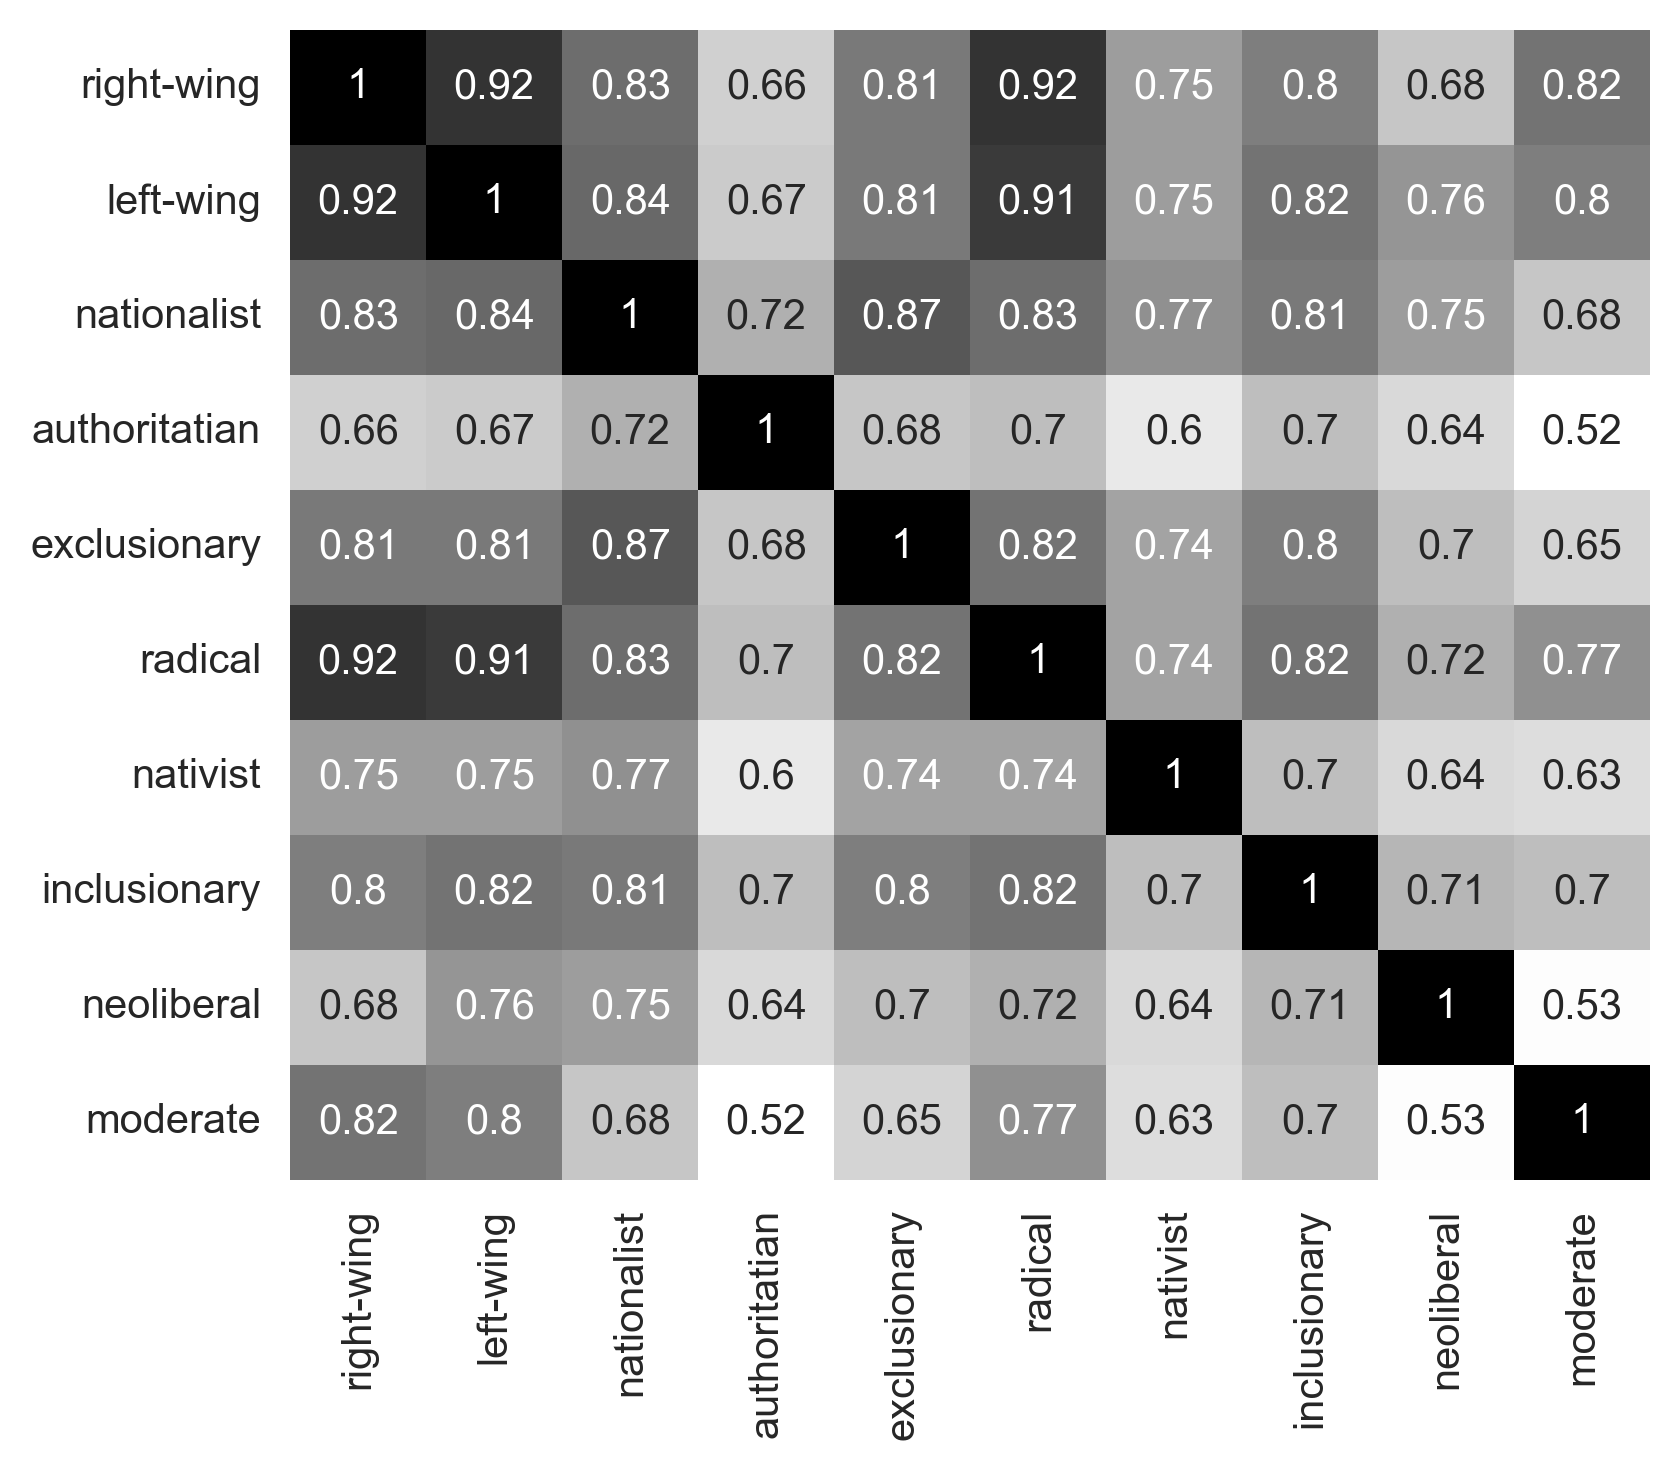

In [199]:
fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)
sns.heatmap(freqs_cossim, annot=True, cbar=None, cmap="Greys") #  , fmt='d', ax=ax)

<AxesSubplot: >

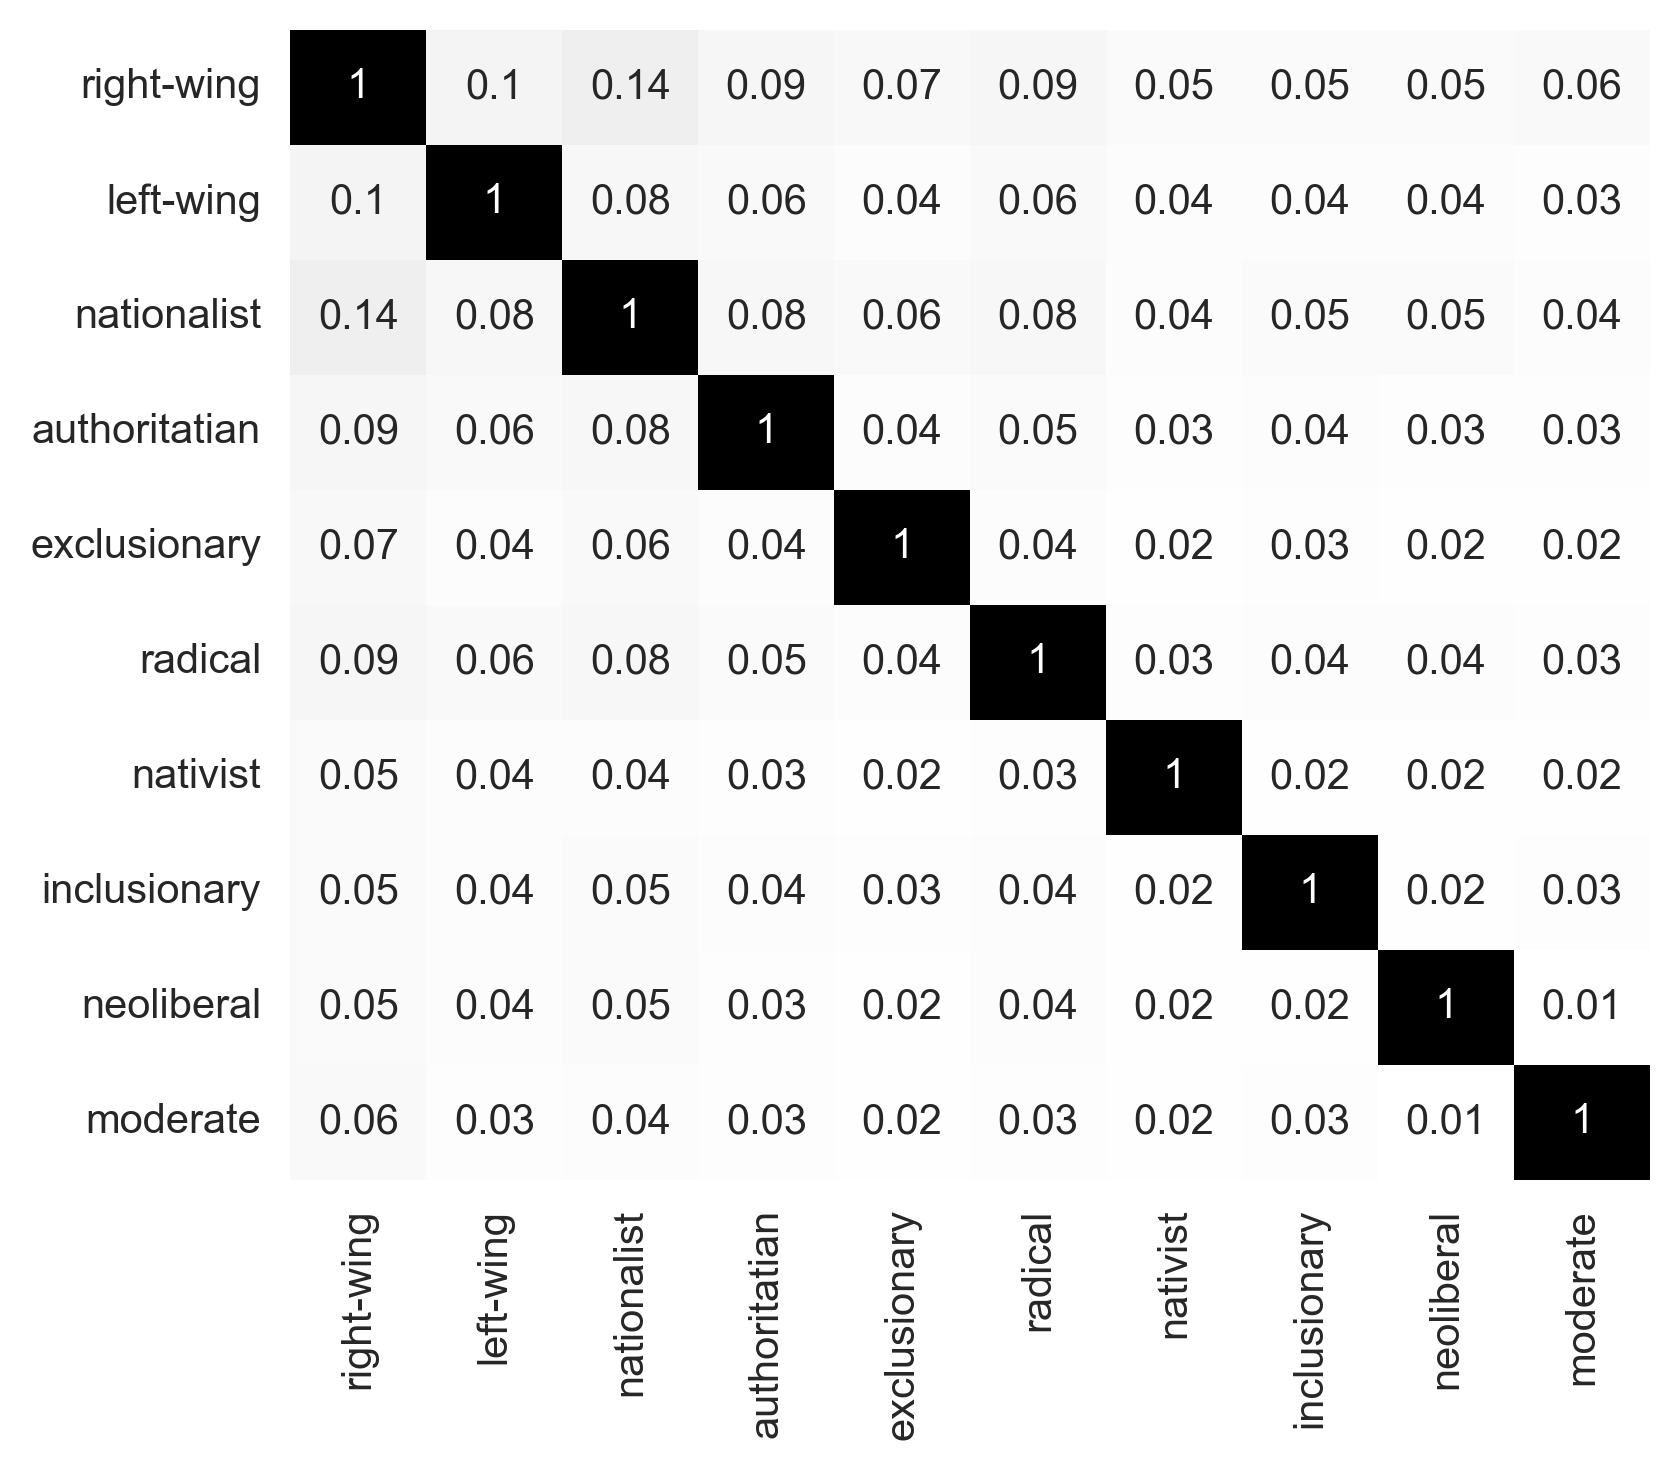

In [205]:
fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)
sns.heatmap(weighted_cossim, annot=True, cbar=None, cmap="Greys") #  , fmt='d', ax=ax)

In [206]:
fig.savefig("../figures/weighted_cossim.png")

<AxesSubplot: >

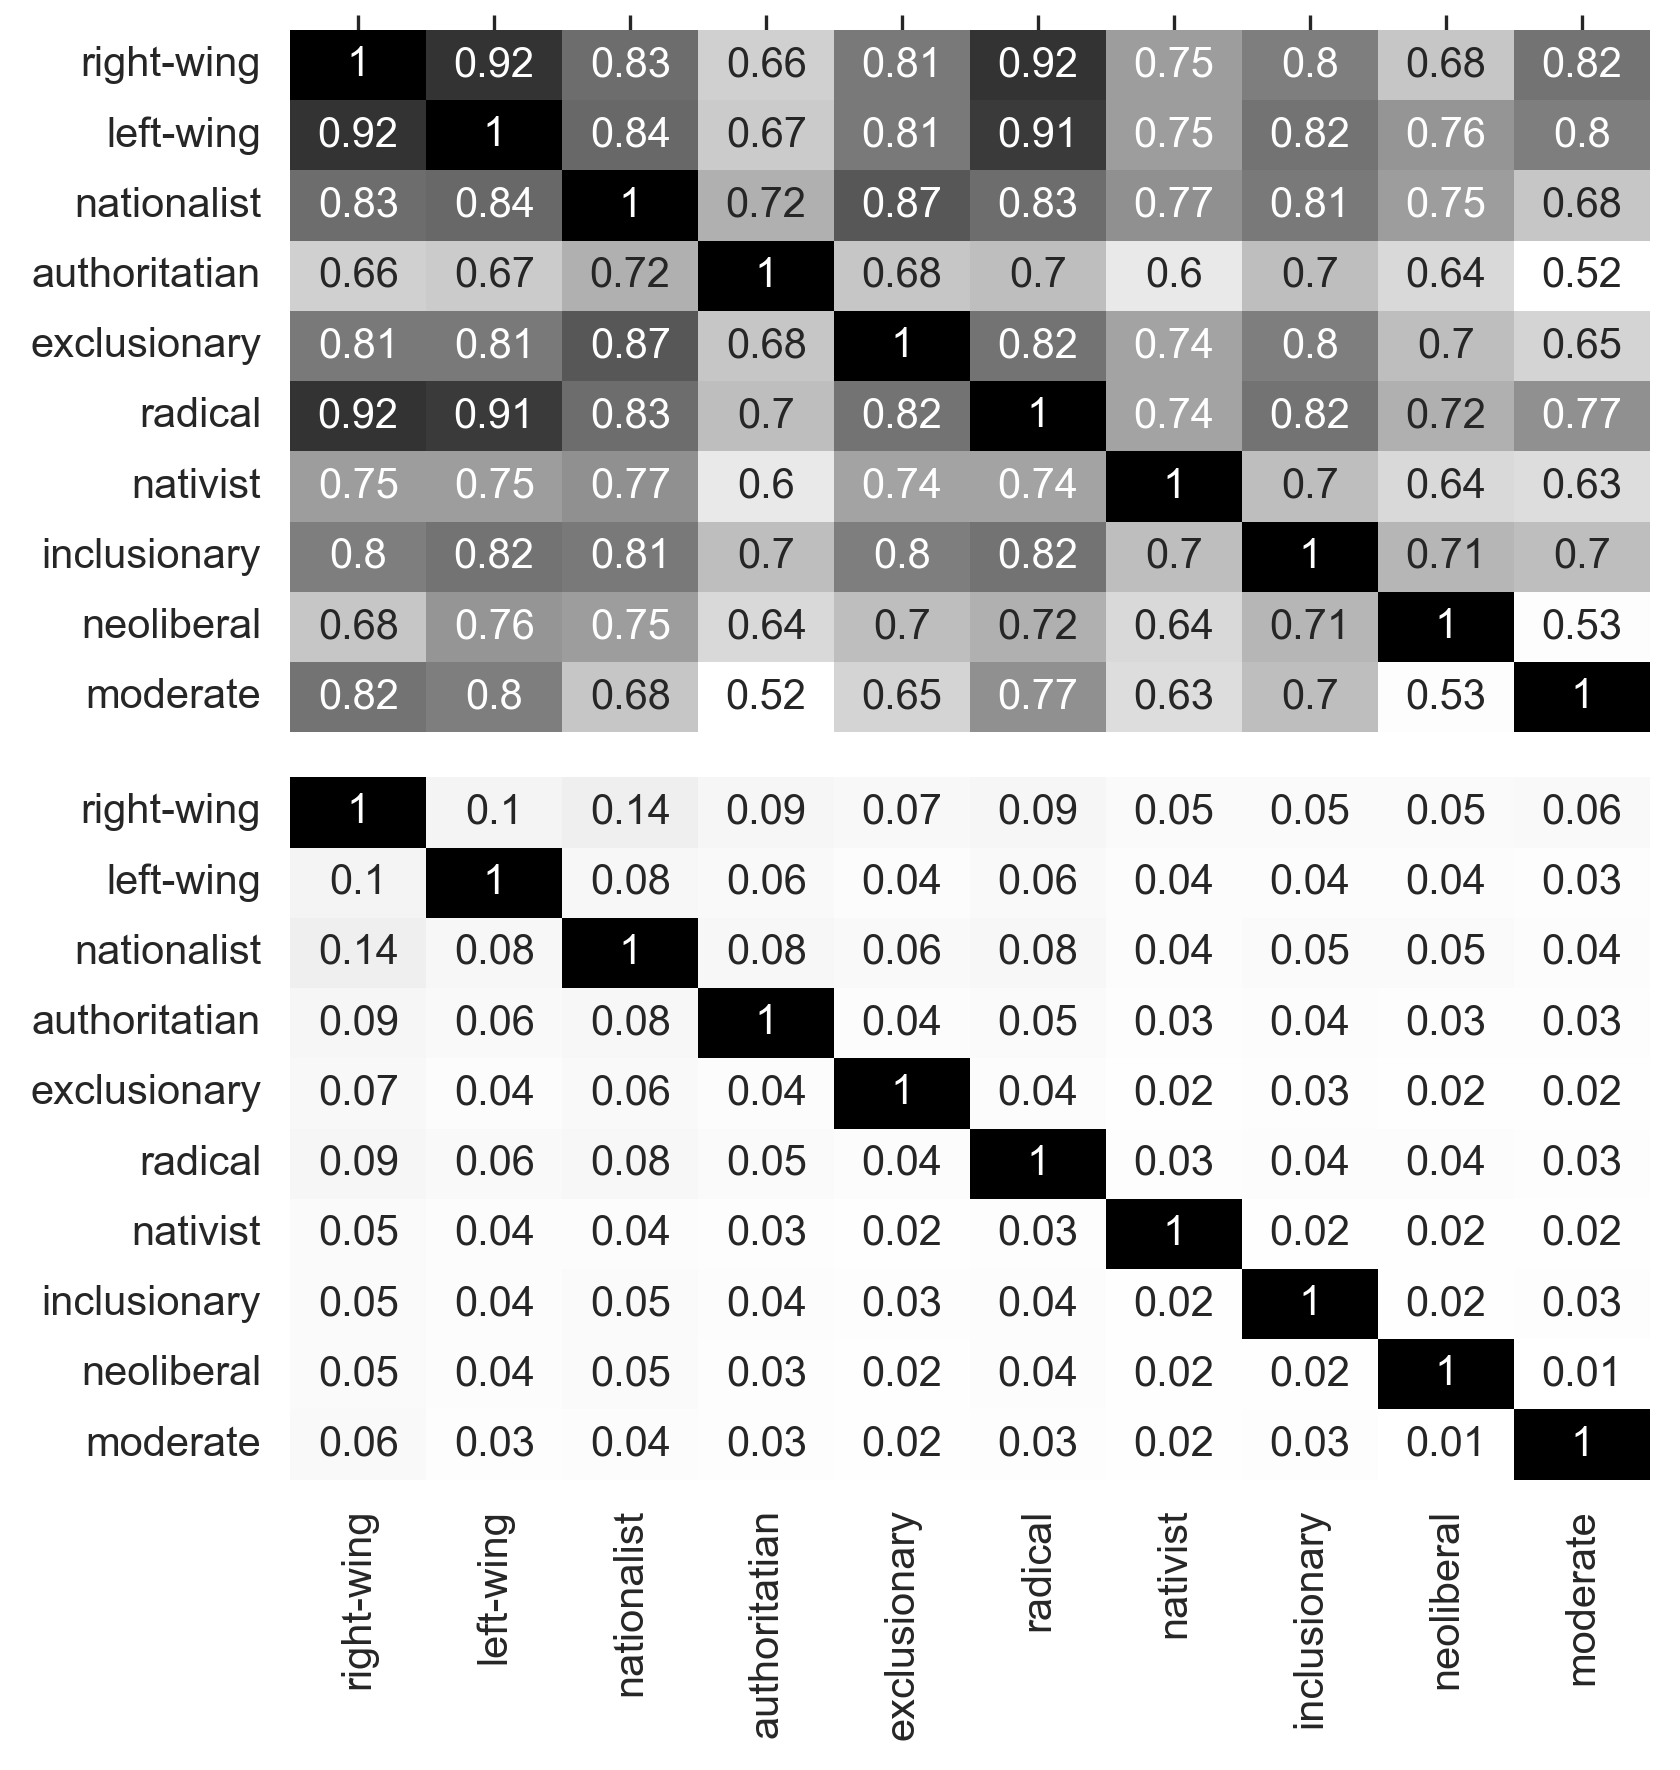

In [207]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5.7, 6), dpi=300, tight_layout=True)
sns.heatmap(freqs_cossim, annot=True, cbar=None, cmap="Greys", ax=ax1)#  , fmt='d', ax=ax)
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top') # the rest is the same
sns.heatmap(weighted_cossim, annot=True, cbar=None, cmap="Greys", ax=ax2) #  , fmt='d', ax=ax)

In [208]:
fig.savefig("../figures/freqs_vs_weighted_cossim.png")

In [189]:
freqs_vals_weighted_df

right-wing  left-wing  nationalist  authoritatian  exclusionary  \
party           1.354859   1.142774     0.621188       0.379213      0.784595   
political       0.950847   0.975117     0.953457       1.049806      1.265444   
people          0.904766   0.649275     1.504469       0.660208      1.632571   
democracy       1.019875   0.677548     0.574002       2.605368      0.890266   
politic         0.822140   0.890621     1.330188       1.100578      1.044601   
...                  ...        ...          ...            ...           ...   
demobilizing    0.000000   0.000000     4.169916       0.000000      0.000000   
tacit           0.000000   0.000000     4.169916       0.000000      0.000000   
colonel         0.000000   0.000000     4.169916       0.000000      0.000000   
pueblo          0.000000   0.000000     4.169916       0.000000      0.000000   
backstoppe      0.000000   0.000000     0.000000       0.000000      0.000000   

               radical  nativist  inclusionary  neoliberal   moderate  
party         1.351600  0.681253      0.806633    0.582005   1.512321  
political     1.218389  0.617788      1.213269    1.351228   0.671825  
people        0.753088  1.026891      0.922898    0.358226   0.476072  
democracy     1.617912  0.569060      0.937625    0.389938   0.549624  
politic       1.104761  0.351498      0.857450    1.538989   0.232795  
...                ...       ...           ...         ...        ...  
demobilizing  0.000000  0.000000      0.000000    0.000000   0.000000  
tacit         0.000000  0.000000      0.000000    0.000000   0.000000  
colonel       0.000000  0.000000      0.000000    0.000000   0.000000  
pueblo        0.000000  0.000000      0.000000    0.000000   0.000000  
backstoppe    0.000000  0.000000      0.000000    0.000000  32.474913  

[9724 rows x 10 columns]

In [191]:
weighted_by_type_dict = {}
for poptype in poptypes:
    weighted_by_type_dict[poptype] = list(freqs_vals_weighted_df.sort_values(poptype, ascending=False).index[:100])
weighted_by_type_df = pd.DataFrame(weighted_by_type_dict)
weighted_by_type_df

right-wing                                          left-wing  \
0                   fifth                                         dissatisfy   
1                prisoner                                        anti-racist   
2           mainstreaming                                           contract   
3             parenthesis                                             fealty   
4           conspicuously                                         conﬂicting   
5                 unowned                                        expropriate   
6                  postal                                     re-nationalize   
7         disrespectfully                                   radical-populist   
8            non-european                                          publicize   
9       disproportionally                                  right-libertarian   
10               quadrant                                     burden-sharing   
11                    für                                      class-related   
12            heroisation                                            shatter   
13                 asylum                                            instill   
14               district                                             breech   
15                oppress                                         outrageous   
16            inefﬁciency                                     aggressiveness   
17                 camera                                   demonopolisation   
18          inexperienced                                        tribunitian   
19                 theses                                        mid-western   
20                     cr                                          signatory   
21              preoccupy                                      renegotiation   
22                     eR                                     women-friendly   
23            humiliation                                        twentyfirst   
24                 pincer                                         patriarchy   
25           oligarchical                                      unambiguously   
26                 forbid                                             vessel   
27          bureaucratism                                                ame   
28               lambaste                                             string   
29              privateer                                      irrationality   
30              cutthroat                                          distanced   
31                  imbed                                             bereft   
32              epitomize                                         wellspring   
33                cursory                                        destination   
34             prowelfare                                             delink   
35                 coddle                                          hamstring   
36                  stock                                          powerless   
37          24-hour-cycle                                          commenter   
38              wellbeing                                     right-populism   
39             profession                                           recovery   
40               eligible                                         outﬂanking   
41                bracket                                          quiescent   
42                  dalit                                          congruous   
43       english-language                                     policy-related   
44                   ical                                  radicaldemocratic   
45                    lag  http://creativetimereports.org/2012/11/15/occu...   
46         self-described                                               hark   
47                   orgy                                             ﬁfteen   
48              repossess                                     interpretative   
49             

In [192]:
google_conf.set_with_dataframe(pop_data.add_worksheet("weighted_by_type_df", 1,1), weighted_by_type_df)

In [193]:
weighted_by_type_df.to_csv("../data/weighted_by_type_df.csv")

# Narrow type approach

In [194]:
concs_covered_types_preceding = []
for conc, year, title in all_concs:
    type = ""
    if len(conc) == 21:
        for key in poptypes_dict.keys():
            if conc[9] in poptypes_dict[key]:
                type = key
    concs_covered_types_preceding.append((conc, type, year, title))

In [195]:
concs_covered_types_preceding_df = pd.DataFrame(concs_covered_types_preceding, columns=["conc", "type", "year", "title"])
concs_covered_types_preceding_df = concs_covered_types_preceding_df[concs_covered_types_preceding_df["type"]!=""]
len(concs_covered_types_preceding_df)

3598

In [196]:
concs_covered_types_preceding_df.groupby("type").size()

type
authoritatian     156
exclusionary      115
inclusionary       65
left-wing         649
moderate           44
nationalist       255
nativist           73
neoliberal         65
radical           111
right-wing       2065
dtype: int64